In [1]:
# All imports


from __future__ import print_function, division

#!pip install monai
import matplotlib.pyplot as plt
import numpy as np
import glob


import SimpleITK as sitk
import pandas as pd
import glob
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans

import csv
from scipy import ndimage, misc
from tqdm import tqdm

import numba
from numba import njit, prange

import os
import skimage.io as io
import skimage.transform as trans
import numpy as np

import scipy
from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu
import matplotlib.patches as patches

import pywt
import numpy as np
#import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage.io as io
#from sklearn.decomposition import PCA
import collections, numpy
import warnings
from scipy import ndimage, misc
warnings.filterwarnings('ignore')
import copy


import os
import glob
import uuid
import numpy as np


import numpy
import warnings

import functools
import pickle
import time


import numpy as np

import argparse
import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable

import torch.nn as nn

from ipywidgets import IntProgress
#from ipywidgets import IProgress
# [STAR] All imports for DBT

import os
import pandas
%matplotlib inline
import matplotlib.pyplot as plt
from duke_dbt_data import dcmread_image, read_boxes, draw_box, evaluate
np.random.seed(0)
#torch.manual_seed(0)!pip install monai

# [STAR] All the Imports

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from pathlib import Path
import ast
import pandas as pd
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import re
import cv2

import random

In [2]:
# [STAR] Pytorch Models for training

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    """
    Attention Block
    """

    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class DoubleConv_3D(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Down_3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv_3D(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class Up_3D(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up   = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv_3D(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class OutConv_3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv_3D, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class SUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        
        self.dp1 = nn.Dropout(p=0.2)
        self.dp2 = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
        
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
        
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
        #x3 = self.dp1(x3)
        
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
        #x4 = self.dp2(x4)
        
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
            
        x = self.up3(x, x2)
        x = self.gn7(x)
        
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class SUNet_3D(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet_3D, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc   = DoubleConv_3D(n_channels, 16)
        self.down1 = Down_3D(16, 32)
        self.down2 = Down_3D(32, 64)
        self.down3 = Down_3D(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down_3D(128, 256 // factor)
        self.up1 = Up_3D(256, 128 // factor, bilinear)
        self.up2 = Up_3D(128, 64 // factor, bilinear)
        self.up3 = Up_3D(64, 32 // factor, bilinear)
        self.up4 = Up_3D(32, 16, bilinear)
        self.outc = OutConv_3D(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        
        self.dp1 = nn.Dropout(p=0.2)
        self.dp2 = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
        
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
        
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
        #x3 = self.dp1(x3)
        
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
        #x4 = self.dp2(x4)
        
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
            
        x = self.up3(x, x2)
        x = self.gn7(x)
        
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class SUNet_with_BN(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet_with_BN, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.BatchNorm2d(16)
        self.gn2 = nn.BatchNorm2d(32)
        self.gn3 = nn.BatchNorm2d(64)
        self.gn4 = nn.BatchNorm2d(128)
        self.gn5 = nn.BatchNorm2d(64)
        self.gn6 = nn.BatchNorm2d(32)
        self.gn7 = nn.BatchNorm2d(16)
        
        self.dp1 = nn.Dropout(p=0.4)
        self.dp2 = nn.Dropout(p=0.4)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
        
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
        
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
            
        x = self.up3(x, x2)
        x = self.gn7(x)
        
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class SUNet_without_GN(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet_without_GN, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        x5 = self.down4(x4)
        x  = self.up1(x5, x4)
        x  = self.up2(x, x3)
        x  = self.up3(x, x2)
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        
        return logits

class AttnDecoderRNN_old(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=256, bilinear=True):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.bilinear = bilinear
        self.n_classes = 1

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        
        self.attn_24 = nn.Linear(self.hidden_size*4, self.hidden_size*2)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.attn_combine_bilstm = nn.Linear(self.hidden_size * 3, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
       # self.hidden = nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda())
       
        self.lsgn_a = nn.GroupNorm(128,256)
    
        self.down5 = Down(128,256)
        
        factor = 2 if bilinear else 1
                
        self.ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        self.upsconv4 = DoubleConv(256,128)

        self.lstm = nn.LSTM(256,256,batch_first=False,bidirectional=True,num_layers=1).cuda()
    
    def forward(self, input,hidden,encoder_outputs):
        
        h = torch.unsqueeze(hidden,0)
        
        embedded = input
        
        embedded = self.dropout(embedded)

        hidden_bilstm = h[0]
        
        
        hidden_bilinn =  hidden_bilstm
        
        hidden_bilinn = self.attn(hidden_bilinn)
    
        hidden_bilinn = self.lsgn_a(hidden_bilinn)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden_bilinn), 1)), dim=1)
        
        
        
        attn_weights  = self.lsgn_a(attn_weights)
    
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
        
   #     print('attn_applied: encoder outputs',attn_applied[0].shape,encoder_outputs[0].shape)

        output = torch.cat((embedded[0], attn_applied[0]), 1)
  #      print('The output shape is : ',output.shape)
        
        output = self.attn_combine_bilstm(output).unsqueeze(0)
 #      print('The output shape after is : ',output.shape)
        
    
        hidden_bi = hidden_bilinn.unsqueeze(0)
        
        output = F.relu(output)
        
        #print("output and hidden before lstm ",output.shape,hidden_bi.shape)

        output, hidden = self.gru(output, hidden_bi)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        output = self.lsgn_a(output)
        
       #output = self.lsgn_a(output)
    
        return output,hidden


    def initHidden(self):
        return torch.randn(4, 256, self.hidden_size, device=device)

############### MAIN MODEL ##############
class UNetDoubleSmallGroupNormdifferent_old(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        
        super(UNetDoubleSmallGroupNormdifferent, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)

        
        self.down5 = Down(128,256)
        
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.lsgn1 = nn.GroupNorm(128,256)
        
        self.lsgn2 = nn.GroupNorm(64,256)
        
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
   
    def forward(self, x):
        x1 = self.inc(x)
       # x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
       # x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
       # x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
       # x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        
        #x5 = torch.squeeze(x5)
        x5 = self.down5(x5)
        #x5 = self.down6(x5)
        
        #print('x5 shape is :',x5.shape)
        
        xlst = x5.reshape([4,256,256])

        lstm = nn.LSTM(256,256,batch_first= True,bidirectional=True,num_layers=1).cuda()
                
        #print('xlst',xlst.shape)    
        
        xlst = self.lsgn1(xlst)
        
        ylst = lstm(xlst)
        
        
        #print(hidden)
        
        f = np.asarray(ylst)
        
        h  = torch.cuda.FloatTensor(ylst[0])
        
        
        h = torch.squeeze(h)
        
        encoder_o = f[0]
        
        a = np.zeros((4,256,256))

        a = torch.from_numpy(a)
        a.cuda()
        
        for i in range(4):
    
            oo,b = attn_decoder1.forward(xlst,h[i],encoder_o[i])
            oo = self.lsgn2(oo)
            a[i] = oo
        
            
        a = a.unsqueeze(0)
        a = a.reshape([4,256,16,16])
        
        
        
        x5 = a  
        x5 = x5.cuda()
        
        
        x5 = x5.type(torch.cuda.FloatTensor)
 
        
        
        x5 = self.lsgn2(x5)
        
        ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        upsconv4 = DoubleConv(256,128)

        ups4 = ups4.cuda()
        
        opt = ups4(x5)
        
        x5 = opt
        
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
       # x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class UNetDoubleSmallGroupNormdifferent(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        super(UNetDoubleSmallGroupNormdifferent, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc     = DoubleConv(n_channels, 16)
        self.down1   = Down(16, 32)
        self.downnew = Down(16,16)
        self.down2   = Down(32, 64)
        self.down3   = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4   = Down(128, 256 // factor) 
        self.upsam   = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.down5 = Down(128,256)
        self.ups3  = nn.ConvTranspose2d(1 , 1, kernel_size=2, stride=2)
        self.ups4  = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.lsgn1 = nn.GroupNorm(64,128)
        self.lsgn2 = nn.GroupNorm(64,1024)
        self.lsgn3 = nn.GroupNorm(64,1024)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        self.gn8 = nn.GroupNorm(4,8)
   
    def forward(self, x):
        #x = self.upsam()
        
        x1 = self.inc(x)
        #x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
        #x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
        #x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
        #x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        #x5 = self.gn
        #x5 = torch.squeeze(x5)
        #x5 = self.down5(x5)
        #x5 = self.down6(x5)
        #print('x5:',x5.shape)
        
        xlst = x5.reshape([4,128,1024])
        

        lstm = nn.LSTM(1024,1024,batch_first= True,bidirectional=True,num_layers=1).cuda()
        
        xlst = self.lsgn1(xlst)
        ylst = lstm(xlst)
        
        f = np.asarray(ylst)
        
        h  = torch.cuda.FloatTensor(ylst[0])
        h = torch.squeeze(h)
        
        encoder_o = f[0]
        
        a = np.zeros((4,128,1024))
        #a = ndarray((4,128,1024))

        a = torch.from_numpy(a)
        a.cuda()
        
        for i in range(4):
            oo,b = attn_decoder1.forward(xlst,h[i],encoder_o[i])
            oo   = self.lsgn2(oo)
            a[i] = oo
        
            
        a = a.unsqueeze(0)
        a = a.reshape([4,128,32,32])
        
        
        x5 = a  
        x5 = x5.cuda()
        
        
        x5 = x5.type(torch.cuda.FloatTensor)
        #x5 = self.lsgn3(x5)
        
        #x5 = self.ups4(x5)
    
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
        #x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        #x = self.gn7(x)

        #x = self.downnew(x)
        
        #out    = self.out_softmax(logits)
        
        logits = self.outc(x)
        
        return logits

class UNetDoubleSmallWithoutGN(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        
        super(UNetDoubleSmallWithoutGN, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc   = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.down5 = Down(128,256)
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
       # x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
       # x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
       # x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
       # x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        
        #x5 = torch.squeeze(x5)
        x5 = self.down5(x5)
        #x5 = self.down6(x5)
        
        ups4     = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        upsconv4 = DoubleConv(256,128)
        ups4 = ups4.cuda()
        
        opt = ups4(x5)
        
        x5 = opt
        
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
       # x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=128, bilinear=True):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p   = dropout_p
        self.max_length  = max_length
        self.bilinear    = bilinear
        self.n_classes   = 1

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn      = nn.Linear(2048, 1024)
        
        self.attn2   = nn.Linear(1024, 128)
        
        self.attn_24 = nn.Linear(self.hidden_size*4, self.hidden_size*2)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.attn_combine_bilstm = nn.Linear(3072, 1024)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru     = nn.GRU(1024, 1024)
        self.out     = nn.Linear(1024, 1024)
       # self.hidden = nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda())
       
        #self.lsgn_a = nn.GroupNorm(512,1024)
        self.lsbn_a1 = nn.BatchNorm1d(1024)
        #self.lsgn_a2 = nn.GroupNorm(512,1024)
        
        #self.lsgn_in = nn.GroupNorm(64,128)
        self.lsbn_in1 = nn.BatchNorm1d(2048)
        self.lsbn_in2 = nn.BatchNorm1d(1024)
        
        
        self.lsbn_in3 = nn.BatchNorm1d(128)#nn.GroupNorm(64,   128)
        self.lsbn_in4 = nn.BatchNorm1d(128)#nn.GroupNorm(64,   128)
        self.lsbn_in5 = nn.BatchNorm1d(1024)#nn.GroupNorm(512,  1024)
        
        self.down5 = Down(128,256)
        
        factor = 2 if bilinear else 1
                
        self.ups4     = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        self.upsconv4 = DoubleConv(256,128)

        self.lstm = nn.LSTM(256,256,batch_first=False,bidirectional=True,num_layers=1).cuda()
    
    def forward(self, input,hidden,encoder_outputs):
        
        h        = torch.unsqueeze(hidden, 0)
        embedded = input
        #embedded = self.lsgn_in1(embedded)
        embedded = self.dropout(embedded)
        
        hidden_bilstm = h[0]
        hidden_bilinn = hidden_bilstm
        
        hidden_bilinn = self.attn(hidden_bilinn)
        hidden_bilinn = self.lsbn_a1(hidden_bilinn)
        
        hidden_bi     = hidden_bilinn.unsqueeze(0)
        
        #print(hidden_bilinn.shape)
        
        attn_weights  = torch.cat((embedded[0], hidden_bilinn), 1)
        attn_weights  = self.lsbn_in1(attn_weights)
        
        attn_weights  = self.attn(attn_weights)
        attn_weights  = self.lsbn_in2(attn_weights)
        
        attn_weights  = F.softmax(attn_weights, dim=1)
        
        attn_weights  = self.attn2(attn_weights)
        attn_weights  = self.lsbn_in3(attn_weights)
        
        #print(attn_weights.unsqueeze(0).shape,encoder_outputs.unsqueeze(0).shape)
    
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        #print('attn_applied: encoder outputs',attn_applied[0].shape,encoder_outputs[0].shape)

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        
        output = self.attn_combine_bilstm(output).unsqueeze(0)
        output = F.relu(output)
        output = self.lsbn_in4(output)
        
        output, hidden = self.gru(output, hidden_bi)
        
        output = self.out(output[0])
        output = self.lsbn_in5(output)
        output = F.log_softmax(output, dim=1)
        return output, hidden


    def initHidden(self):
        return torch.randn(4, 256, self.hidden_size, device=device)

class AttU_Net(nn.Module):
    """
    Attention Unet implementation
    Paper: https://arxiv.org/abs/1804.03999
    """
    def __init__(self, img_ch=1, output_ch=1):
        super(AttU_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

        #self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        #print(x5.shape)
        d5 = self.Up5(e5)
        #print(d5.shape)
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

      #  out = self.active(out)

        return out
    
class UNetNormal(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNetNormal, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        my_factor = 1
        factor    = 1
        
        self.inc   = DoubleConv(n_channels, 32*my_factor)
        self.down1 = Down(32*my_factor, 64*my_factor)
        self.down2 = Down(64*my_factor, 128*my_factor)
        self.down3 = Down(128*my_factor, 256*my_factor)
        factor = 2 if bilinear else 1
        self.down4 = Down(256*my_factor, 512*my_factor // factor)
        
        self.lsgn1 = nn.GroupNorm(256,512)
        self.lsgn2 = nn.GroupNorm(512,1024)
        
        self.up1 = Up(512*my_factor, 256*my_factor // factor, bilinear)
        self.up2 = Up(256*my_factor, 128*my_factor // factor, bilinear)
        self.up3 = Up(128*my_factor, 64*my_factor // factor, bilinear)
        self.up4 = Up(64*my_factor, 32*my_factor, bilinear)
        self.outc = OutConv(32*my_factor, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        #self.out_softmax = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

#model = SUNet_3D(1, 1)
#model.cuda()

In [ ]:
# [STAR] Read all the slices in training set without augmentation

basepath = '/home/drilnvm/DBTex/'
df = read_boxes(boxes_fp=basepath+"BCS-DBT-boxes-train.csv", filepaths_fp=basepath+"BCS-DBT-file-paths-train.csv")


trainx = []
trainy = []
boximage  = []
coordx =  []
coordy = []

width_arr = []
height_arr = []

for i in tqdm(range(224)):
    box_series  = df.iloc[i]
    view        = box_series["View"]
    slice_index = box_series["Slice"]
    image_path  = os.path.join(basepath, box_series["descriptive_path"])
    image       = dcmread_image(fp=image_path, view=view, index=slice_index-1)
    
    #trainx.append(image[slice_index-1:slice_index+1])
    #trainx.append(image[slice_index])
    trainx.append(image)
    trainy.append(box_series["Class"])
    #image = image[slice_index]
    
    x, y, width, height = box_series[["X", "Y", "Width", "Height"]]
    #image               = draw_box(image=image, x=x, y=y, width=width, height=height, lw=10)
    #boximage.append(image)
    coordx.append(x)
    coordy.append(y)
    width_arr.append(width)
    height_arr.append(height)

print(len(trainx), len(trainy), len(boximage))

# mx = 0
# my = 0
# for i in range(len(trainx)):
#     if trainx[i].shape[0] > mx:
#         mx = trainx[i].shape[0]
#     if trainx[i].shape[1] > my:
#         my = trainx[i].shape[1]
# print(mx, my)

if(1):
    np.save('coordx.npy', coordx)
    np.save('coordy.npy', coordy)

    newtrainx  = np.zeros([len(trainx), 1, 3000, 2000], 'float16')
    newtrainy  = np.zeros([len(trainx), 1], 'float16')
    for i in range(len(trainx)):
        newtrainx[i, 0, :trainx[i].shape[0], :trainx[i].shape[1]] = trainx[i]
        if trainy[i] == 'benign':
            newtrainy[i, 0] = 0
        else:
            newtrainy[i, 0] = 1

    np.save('trainx.npy', newtrainx)
    np.save('trainy.npy', newtrainy)

In [56]:
# [STAR] DBT classes for data loader

class DBTDataset(torch.utils.data.Dataset):
    def __init__(self, train_set = 1, transforms = None):
        super().__init__()
        
        suffix_str  = ''#random.choice(['_m2', '_m1', '_p1', '_p2', ''])
        print('READING NEW FILE >> ', suffix_str, ' <<')
        
        #shuffle_index = np.arange(224)
        #np.random.shuffle(shuffle_index)
        #np.save('shuffle_array.npy', shuffle_index)
        #shuffle_index = np.load('shuffle_array.npy')
        
        trainx = np.load('trainx'+suffix_str+'.npy')
        trainy = np.load('trainy'+suffix_str+'.npy')
        coordx = np.load('coordx'+suffix_str+'.npy')
        coordy = np.load('coordy'+suffix_str+'.npy')
        width_arr  = np.load('width_arr'+suffix_str+'.npy')
        height_arr = np.load('height_arr'+suffix_str+'.npy')
        
        #trainx = trainx[shuffle_index]
        #trainy = trainy[shuffle_index]
        #coordx = coordx[shuffle_index]
        #coordy = coordy[shuffle_index]
        #width_arr  = width_arr[shuffle_index]
        #height_arr = height_arr[shuffle_index]
        
        self.counter = 0
        if train_set == 1:
            self.train_start  = 0
            self.train_end    = 175
        else:
            self.train_start  = 175
            self.train_end    = 220
        
        self.train_set = train_set
        #t1 = np.load('trainx_m1.npy')[self.train_start:self.train_end]
        #t2 = np.load('trainx.npy')[self.train_start:self.train_end]
        #t3 = np.load('trainx_p1.npy')[self.train_start:self.train_end]
        #self.trainx  =  np.concatenate([t2, t1, t3], axis=1)
        
        self.trainx = trainx[self.train_start:self.train_end]#.astype('float16')/60000.0
        self.trainy = trainy[self.train_start:self.train_end]
        self.coordx = coordx[self.train_start:self.train_end]
        self.coordy = coordy[self.train_start:self.train_end]
        self.width_arr  = width_arr[self.train_start:self.train_end]
        self.height_arr = height_arr[self.train_start:self.train_end]
        
        print('Total size of dataset ', len(np.load('width_arr'+suffix_str+'.npy')))
#         self.trainx = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainx.npy')[self.train_start:self.train_end]#.astype('float16')/60000.0
#         self.trainy = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainy.npy')[self.train_start:self.train_end]
#         self.coordx = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordx.npy')[self.train_start:self.train_end]
#         self.coordy = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordy.npy')[self.train_start:self.train_end]
#         self.width_arr  = np.load('/media/yu-hao/WindowsData/DBT_numpy/width_arr.npy')[self.train_start:self.train_end]
#         self.height_arr = np.load('/media/yu-hao/WindowsData/DBT_numpy/height_arr.npy')[self.train_start:self.train_end]
        
        self.transforms1 = A.Compose(
                                    [A.HorizontalFlip(p=0.5),  A.VerticalFlip(p=0.5), ],
                                     #A.Downscale(scale_min=0.95, scale_max=0.98, p=0.25, interpolation=3),],
                                    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
                                   )
        
    def __getitem__(self, idx):
        self.counter = self.counter+1
        #if self.counter % 10 == 0:
        #    print('Counter is ', self.counter)
        
#         if self.train_set == 1 and self.counter % 150 == 0 and random.random() < 0.2:
#             suffix_str  = random.choice([ '_m1', '_p1', ''])
#             print('READING NEW FILE >> ', suffix_str, ' <<')
#             self.trainx = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainx'+suffix_str+'.npy')[self.train_start:self.train_end]#.astype('float16')/60000.0
#             self.trainy = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainy'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.coordx = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordx'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.coordy = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordy'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.width_arr  = np.load('/media/yu-hao/WindowsData/DBT_numpy/width_arr'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.height_arr = np.load('/media/yu-hao/WindowsData/DBT_numpy/height_arr'+suffix_str+'.npy')[self.train_start:self.train_end]
                
        #img = self.trainx[idx].astype('float32')/60000.0
        img = self.trainx[idx, 0].astype('float32')/60000.0
        img[img > 1] = 1
        img = ndimage.interpolation.zoom(img, 0.25)
        img = np.expand_dims(img, 0)
        img = np.concatenate([img, img, img], axis=0)
        
        if(self.train_set == 1):
            img = np.moveaxis(img, 0, -1)
        
        boxes = np.array([self.coordx[idx]/4, self.coordy[idx]/4, self.width_arr[idx]/4, self.height_arr[idx]/4])#records[['x', 'y', 'w', 'h']].values
        boxes = np.expand_dims(boxes, axis=0)
        boxes[:, 2] = boxes[:, 0]+boxes[:, 2]
        boxes[:, 3] = boxes[:, 1]+boxes[:, 3]
        
        area = self.width_arr[idx] * self.height_arr[idx]
        area = torch.Tensor(area)
        
        # there is only one class
        labels =  torch.ones((1,)).type(torch.int64)
        
        if(self.train_set == 1):
        #if(0):
            transformed = self.transforms1(image=img, bboxes=boxes, labels=labels)
            image    = transformed['image']
            boxes    = np.array(transformed['bboxes'])
            img      = np.moveaxis(image, 2, 0)
        
        # suppose all instances are not crowd
        iscrowd = torch.Tensor(np.array([0])).type(torch.int64)
        
        target              = {}
        target['boxes']     = torch.Tensor(boxes)
        target['labels']    = labels
        target['image_id']  = torch.tensor([idx])
        target['area']      = area
        target['iscrowd']   = iscrowd
        
        return img, target, idx
    
    def __len__(self):
        return self.trainx.shape[0]

class DBTDatasetValidation(torch.utils.data.Dataset):
    def __init__(self, val_index = 0, transforms = None):
        super().__init__()
        
        self.basepath  = '/home/drilnvm/DBTex/'
        self.counter   = 0
        self.val_index = val_index
        self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-train.csv')
        #self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-validation.csv')
        
        box_series       = self.df.iloc[self.val_index]
        self.PatientID   = box_series["PatientID"]
        self.StudyUID    = box_series["StudyUID"]
        self.view        = box_series["View"]
        
        image_path      = os.path.join(self.basepath, box_series["descriptive_path"])
        self.vol        = dcmread_image(fp=image_path, view=self.view)
        self.newtrainx  = np.zeros([len(self.vol), 1, 3000, 2000], 'float16')
        for i in range(len(self.vol)):
            self.newtrainx[i, 0, :self.vol[i].shape[0], :self.vol[i].shape[1]] = self.vol[i]
        
        print('File reading done ', self.vol.shape, image_path)
        #print()
        
    def __getitem__(self, idx):
        
        img          = self.newtrainx[idx, 0].astype('float32')/60000.0
        img[img > 1] = 1
        img = ndimage.interpolation.zoom(img, 0.25)
        img = np.expand_dims(img, 0)
        img = np.concatenate([img, img, img], axis=0)
        
        target              = {}
        target['image_id']  = torch.tensor([idx])
        
        return img, target, idx
    
    def __len__(self):
        return self.vol.shape[0]

class DBTDatasetValidationTrain(torch.utils.data.Dataset):
    def __init__(self, val_index = 0, transforms = None):
        super().__init__()
        
        self.basepath  = '/home/drilnvm/DBTex/'
        self.counter   = 0
        self.val_index = val_index
        #self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-boxes-validation.csv')
        #self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-boxes-train.csv')
        self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-validation.csv')
        
        box_series       = self.df.iloc[self.val_index]
        self.PatientID   = box_series["PatientID"]
        self.StudyUID    = box_series["StudyUID"]
        self.view        = box_series["View"]
        if(0):
            self.slice_index = box_series["Slice"]
            self.X           = box_series["X"]
            self.Y           = box_series["Y"]
            self.Width       = box_series["Width"]
            self.Height      = box_series["Height"]
        #Slice,X,Y,Width,Height
        
        #image_path      = os.path.join(self.basepath, box_series["descriptive_path"])
        self.vol = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy/'+self.PatientID+'_'+self.StudyUID+'_'+self.view+'.npy')
        #self.vol        = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy1/val_vol_'+str(val_index)+'.npy')#dcmread_image(fp=image_path, view=self.view)
        self.newtrainx  = np.expand_dims(self.vol, 1)#np.zeros([len(self.vol), 1, 750, 500], 'float16')
        #for i in range(len(self.vol)):
        #    self.newtrainx[i, 0, :self.vol[i].shape[0], :self.vol[i].shape[1]] = self.vol[i]
        print('File reading done ',            self.vol.shape)
        #print('Inside DBTDatasetValidationTrain ', box_series)
        
        #print(box_series["descriptive_path"])
        
    def __getitem__(self, idx):
        img          = self.newtrainx[idx, 0].astype('float32')#/60000.0
        img[img > 1] = 1
        #img = ndimage.interpolation.zoom(img, 0.25)
        img = np.expand_dims(img, 0)
        img = np.concatenate([img, img, img], axis=0)
        
        target              = {}
        #if idx == self.slice_index:
        #    target['boxes']  = torch.tensor([self.X, self.Y, self.X+self.Width, self.Y+self.Height])
        
        return img, target, idx
    
    def __len__(self):
        return self.vol.shape[0]

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [41]:
# [STAR] DBT Dataset and Model Creation

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset     = DBTDataset(train_set=1)
valid_dataset     = DBTDataset(train_set=0)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=1, collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1, collate_fn=collate_fn
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#model       = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)
params       = [p for p in model.parameters() if p.requires_grad]
optimizer    = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0001)
lr_scheduler = None

READING NEW FILE >>    <<
Total size of dataset  224
READING NEW FILE >>    <<
Total size of dataset  224


In [42]:
# [STAR] Training loop for DBT dataset

loss_hist     = Averager()
val_loss_hist = Averager()

prev_min   = 1000
num_epochs = 10
for epoch in range(num_epochs):
    loss_hist.reset()
    loss_hist.reset()
    
    model.train()
    itr = 1
    for images, targets, image_ids in train_data_loader:
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))
        
        images    = new_images
        targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses     = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        #if itr % 50 == 0:
        #    print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    with torch.no_grad():
        for images, targets, image_ids in valid_data_loader:
            new_images  = []
            for img in images:
                new_images.append(torch.Tensor(img).to(device))

            images    = new_images
            targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            #print(loss_dict)

            losses     = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            val_loss_hist.send(loss_value)

            #if itr % 50 == 0:
            #    print(f"Validation Iteration #{itr} loss: {loss_value}")
            itr = itr+1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    
    if val_loss_hist.value < prev_min:
        print(f"Epoch #{epoch} Train loss: {loss_hist.value}")
        print(f"Epoch #{epoch} Val   loss: {val_loss_hist.value}")
        print('Saving the model ', prev_min, val_loss_hist.value)
        torch.save(model.state_dict(), 'fasterrcnn_resnet50_dbt25.pth')
        prev_min = val_loss_hist.value

Epoch #0 Train loss: 0.24805516038428654
Epoch #0 Val   loss: 0.20107608354753917
Saving the model  1000 0.20107608354753917
Epoch #1 Train loss: 0.19063299995931712
Epoch #1 Val   loss: 0.1944615145524343
Saving the model  0.20107608354753917 0.1944615145524343
Epoch #2 Train loss: 0.17734958468513054
Epoch #2 Val   loss: 0.18896096445344113
Saving the model  0.1944615145524343 0.18896096445344113
Epoch #3 Train loss: 0.16284725290130486
Epoch #3 Val   loss: 0.18728316101349063
Saving the model  0.18896096445344113 0.18728316101349063


In [43]:
# [STAR] For printing the loss of the trained model

# fasterrcnn_resnet50_dbt7.pth  0.24080992616713048
# fasterrcnn_resnet50_dbt8.pth  0.1653416310250759
# fasterrcnn_resnet50_dbt9.pth  0.17630461007356643
# fasterrcnn_resnet50_dbt10.pth 0.17438715264201166
# fasterrcnn_resnet50_dbt11.pth 0.16590506657958032
# fasterrcnn_resnet50_dbt14.pth 0.1608045955002308
# fasterrcnn_resnet50_dbt21.pth 0.15965028703212739
# fasterrcnn_resnet50_dbt15.pth (3 adjacent channel)

all_target    = []
all_scores    = []
val_loss_hist = Averager()
itr = 1

#device = torch.device("cpu")
#model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt25.pth'))
model.train()

with torch.no_grad():
    for images, targets, image_ids in valid_data_loader:
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))

        images    = new_images
        targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        #print(loss_dict)

        losses     = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_hist.send(loss_value)

        if itr % 10 == 0:
            print(f"Validation Iteration #{itr} loss: {loss_value}")
        itr = itr+1

print(val_loss_hist.value)

Validation Iteration #10 loss: 0.15957418084144592
Validation Iteration #20 loss: 0.2850976288318634
Validation Iteration #30 loss: 0.21906031668186188
Validation Iteration #40 loss: 0.2091214954853058
0.18152466780609555


In [57]:
# [STAR] For Obtaining the result on Validation set of the Challenge

def collate_fn(batch):
    return tuple(zip(*batch))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt25.pth'))
model.eval()


trainx = []
trainy = []
boximage  = []
coordx =  []
coordy = []

width_arr  = []
height_arr = []

PatientID_arr = []
StudyUID_arr  = []

#device = torch.device("cpu")
#model.to(device)


import pickle

#shuffle_index = np.load('shuffle_array.npy')
#shuffle_index = shuffle_index[150:]
        
basepath = '/home/drilnvm/DBTex/'
#df = read_boxes(boxes_fp=basepath+"BCS-DBT-boxes-train.csv", filepaths_fp=basepath+"BCS-DBT-file-paths-train.csv")
df = pd.read_csv(basepath+"BCS-DBT-file-paths-validation.csv")
    
for i in tqdm(range(len(df))):
    #if i in shuffle_index:
    
    #else:
    #    continue
    box_series  = df.iloc[i]
    PatientID   = box_series["PatientID"]
    StudyUID    = box_series["StudyUID"]
    view        = box_series["View"]
    
    print('Processing ', i, PatientID, StudyUID, view)
    
    #slice_index = box_series["Slice"]
    #image_path  = os.path.join(basepath, box_series["descriptive_path"])
    #print(box_series)
    
    valid_dataset     = DBTDatasetValidationTrain(val_index=i)
    #valid_dataset     = DBTDataset(train_set=0)
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=1, 
        collate_fn=collate_fn
    )
        
    all_target = []
    all_scores = []
    all_images = []
    
    for images, targets, image_ids in valid_data_loader:
        #print(targets)
        all_images.append(images[0][0].astype('float16'))
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))

        images    = new_images
        #targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images)
        #print(loss_dict)
        
        all_scores.append(loss_dict[0]['scores'].data.cpu().numpy())
        all_target.append(loss_dict[0]['boxes'].data.cpu().numpy())
    
    with open('/media/drilnvm/ubuntudata2/DBTEx_results25_validation/'+PatientID+'_'+StudyUID+'_'+view+'_score_'+str(i)+'.data', 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(all_scores, filehandle)
        
    with open('/media/drilnvm/ubuntudata2/DBTEx_results25_validation/'+PatientID+'_'+StudyUID+'_'+view+'_target_'+str(i)+'.data', 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(all_target, filehandle)
    
    #np.save('/media/drilnvm/ubuntudata2/DBTEx_numpy2/val_vol_'+str(i), np.array(all_images).astype('float16'))

  0%|          | 0/395 [00:00<?, ?it/s]

Processing  0 DBT-P00002 DBT-S03345 lcc
File reading done  (71, 750, 500)


  0%|          | 1/395 [00:04<30:58,  4.72s/it]

Processing  1 DBT-P00002 DBT-S03345 lmlo
File reading done  (65, 750, 500)


  1%|          | 2/395 [00:08<29:40,  4.53s/it]

Processing  2 DBT-P00002 DBT-S03345 rcc
File reading done  (68, 750, 500)


  1%|          | 3/395 [00:13<29:08,  4.46s/it]

Processing  3 DBT-P00002 DBT-S03345 rmlo
File reading done  (61, 750, 500)


  1%|          | 4/395 [00:16<27:55,  4.29s/it]

Processing  4 DBT-P00114 DBT-S03767 rmlo
File reading done  (64, 750, 500)


  1%|▏         | 5/395 [00:21<27:23,  4.21s/it]

Processing  5 DBT-P00160 DBT-S00785 lcc
File reading done  (69, 750, 500)


  2%|▏         | 6/395 [00:25<27:38,  4.26s/it]

Processing  6 DBT-P00160 DBT-S00785 lmlo
File reading done  (65, 750, 500)


  2%|▏         | 7/395 [00:29<27:21,  4.23s/it]

Processing  7 DBT-P00176 DBT-S02289 lcc
File reading done  (73, 750, 500)


  2%|▏         | 8/395 [00:34<28:01,  4.35s/it]

Processing  8 DBT-P00176 DBT-S02289 lmlo
File reading done  (73, 750, 500)


  2%|▏         | 9/395 [00:38<28:35,  4.44s/it]

Processing  9 DBT-P00176 DBT-S02289 rcc
File reading done  (76, 750, 500)


  3%|▎         | 10/395 [00:43<29:11,  4.55s/it]

Processing  10 DBT-P00176 DBT-S02289 rmlo
File reading done  (74, 750, 500)


  3%|▎         | 11/395 [00:48<29:26,  4.60s/it]

Processing  11 DBT-P00213 DBT-S01181 lcc
File reading done  (67, 750, 500)


  3%|▎         | 12/395 [00:52<28:46,  4.51s/it]

Processing  12 DBT-P00213 DBT-S01181 lmlo
File reading done  (81, 750, 500)


  3%|▎         | 13/395 [00:57<29:54,  4.70s/it]

Processing  13 DBT-P00238 DBT-S04801 lcc
File reading done  (61, 750, 500)


  4%|▎         | 14/395 [01:01<28:27,  4.48s/it]

Processing  14 DBT-P00238 DBT-S04801 lmlo
File reading done  (67, 750, 500)


  4%|▍         | 15/395 [01:06<27:59,  4.42s/it]

Processing  15 DBT-P00238 DBT-S04801 rcc
File reading done  (60, 750, 500)


  4%|▍         | 16/395 [01:09<26:47,  4.24s/it]

Processing  16 DBT-P00238 DBT-S04801 rmlo
File reading done  (67, 750, 500)


  4%|▍         | 17/395 [01:14<26:50,  4.26s/it]

Processing  17 DBT-P00351 DBT-S00274 lcc
File reading done  (69, 750, 500)


  5%|▍         | 18/395 [01:18<27:09,  4.32s/it]

Processing  18 DBT-P00351 DBT-S00274 lmlo
File reading done  (76, 750, 500)


  5%|▍         | 19/395 [01:23<28:04,  4.48s/it]

Processing  19 DBT-P00351 DBT-S00274 rcc
File reading done  (72, 750, 500)


  5%|▌         | 20/395 [01:28<28:08,  4.50s/it]

Processing  20 DBT-P00351 DBT-S00274 rmlo
File reading done  (75, 750, 500)


  5%|▌         | 21/395 [01:32<28:38,  4.59s/it]

Processing  21 DBT-P00385 DBT-S04406 lcc
File reading done  (39, 750, 500)


  6%|▌         | 22/395 [01:35<24:40,  3.97s/it]

Processing  22 DBT-P00385 DBT-S04406 lmlo
File reading done  (42, 750, 500)


  6%|▌         | 23/395 [01:38<22:17,  3.59s/it]

Processing  23 DBT-P00385 DBT-S04406 rcc
File reading done  (42, 750, 500)


  6%|▌         | 24/395 [01:40<20:33,  3.32s/it]

Processing  24 DBT-P00385 DBT-S04406 rmlo
File reading done  (38, 750, 500)


  6%|▋         | 25/395 [01:43<18:51,  3.06s/it]

Processing  25 DBT-P00431 DBT-S03956 rmlo
File reading done  (86, 750, 500)


  7%|▋         | 26/395 [01:48<23:17,  3.79s/it]

Processing  26 DBT-P00450 DBT-S04563 lcc
File reading done  (66, 750, 500)


  7%|▋         | 27/395 [01:52<23:58,  3.91s/it]

Processing  27 DBT-P00450 DBT-S04563 lmlo
File reading done  (72, 750, 500)


  7%|▋         | 28/395 [01:57<25:14,  4.13s/it]

Processing  28 DBT-P00450 DBT-S04563 rcc
File reading done  (61, 750, 500)


  7%|▋         | 29/395 [02:01<24:46,  4.06s/it]

Processing  29 DBT-P00450 DBT-S04563 rmlo
File reading done  (70, 750, 500)


  8%|▊         | 30/395 [02:05<25:27,  4.18s/it]

Processing  30 DBT-P00547 DBT-S03787 lcc
File reading done  (60, 750, 500)


  8%|▊         | 31/395 [02:09<24:44,  4.08s/it]

Processing  31 DBT-P00547 DBT-S03787 lmlo
File reading done  (67, 750, 500)


  8%|▊         | 32/395 [02:14<25:03,  4.14s/it]

Processing  32 DBT-P00547 DBT-S03787 rcc
File reading done  (59, 750, 500)


  8%|▊         | 33/395 [02:17<24:18,  4.03s/it]

Processing  33 DBT-P00547 DBT-S03787 rmlo
File reading done  (67, 750, 500)


  9%|▊         | 34/395 [02:22<24:42,  4.11s/it]

Processing  34 DBT-P00549 DBT-S00512 lcc
File reading done  (72, 750, 500)


  9%|▉         | 35/395 [02:26<25:30,  4.25s/it]

Processing  35 DBT-P00549 DBT-S00512 lmlo
File reading done  (68, 750, 500)


  9%|▉         | 36/395 [02:31<25:37,  4.28s/it]

Processing  36 DBT-P00577 DBT-S02359 lcc
File reading done  (65, 750, 500)


  9%|▉         | 37/395 [02:35<25:17,  4.24s/it]

Processing  37 DBT-P00577 DBT-S02359 lmlo
File reading done  (68, 750, 500)


 10%|▉         | 38/395 [02:39<25:21,  4.26s/it]

Processing  38 DBT-P00577 DBT-S02359 rcc
File reading done  (69, 750, 500)


 10%|▉         | 39/395 [02:43<25:31,  4.30s/it]

Processing  39 DBT-P00577 DBT-S02359 rmlo
File reading done  (66, 750, 500)


 10%|█         | 40/395 [02:48<25:16,  4.27s/it]

Processing  40 DBT-P00651 DBT-S04585 lcc
File reading done  (47, 750, 500)


 10%|█         | 41/395 [02:51<23:00,  3.90s/it]

Processing  41 DBT-P00651 DBT-S04585 lmlo
File reading done  (52, 750, 500)


 11%|█         | 42/395 [02:54<21:56,  3.73s/it]

Processing  42 DBT-P00651 DBT-S04585 rcc
File reading done  (48, 750, 500)


 11%|█         | 43/395 [02:57<20:46,  3.54s/it]

Processing  43 DBT-P00651 DBT-S04585 rmlo
File reading done  (48, 750, 500)


 11%|█         | 44/395 [03:00<19:57,  3.41s/it]

Processing  44 DBT-P00655 DBT-S00319 rcc
File reading done  (52, 750, 500)


 11%|█▏        | 45/395 [03:04<19:49,  3.40s/it]

Processing  45 DBT-P00655 DBT-S00319 rmlo
File reading done  (60, 750, 500)


 12%|█▏        | 46/395 [03:07<20:33,  3.53s/it]

Processing  46 DBT-P00697 DBT-S04996 lcc
File reading done  (75, 750, 500)


 12%|█▏        | 47/395 [03:12<22:39,  3.91s/it]

Processing  47 DBT-P00697 DBT-S04996 lmlo
File reading done  (73, 750, 500)


 12%|█▏        | 48/395 [03:17<23:54,  4.13s/it]

Processing  48 DBT-P00697 DBT-S04996 rcc
File reading done  (79, 750, 500)


 12%|█▏        | 49/395 [03:22<25:21,  4.40s/it]

Processing  49 DBT-P00697 DBT-S04996 rmlo
File reading done  (75, 750, 500)


 13%|█▎        | 50/395 [03:27<26:02,  4.53s/it]

Processing  50 DBT-P00714 DBT-S01360 rcc
File reading done  (63, 750, 500)


 13%|█▎        | 51/395 [03:31<25:07,  4.38s/it]

Processing  51 DBT-P00714 DBT-S01360 rmlo
File reading done  (72, 750, 500)


 13%|█▎        | 52/395 [03:35<25:25,  4.45s/it]

Processing  52 DBT-P00718 DBT-S03965 lcc
File reading done  (94, 750, 500)


 13%|█▎        | 53/395 [03:41<27:57,  4.91s/it]

Processing  53 DBT-P00718 DBT-S03965 lmlo
File reading done  (93, 750, 500)


 14%|█▎        | 54/395 [03:47<29:37,  5.21s/it]

Processing  54 DBT-P00718 DBT-S03965 rcc
File reading done  (88, 750, 500)


 14%|█▍        | 55/395 [03:53<30:12,  5.33s/it]

Processing  55 DBT-P00718 DBT-S03965 rmlo
File reading done  (93, 750, 500)


 14%|█▍        | 56/395 [03:59<31:07,  5.51s/it]

Processing  56 DBT-P00843 DBT-S03062 lcc
File reading done  (63, 750, 500)


 14%|█▍        | 57/395 [04:03<28:30,  5.06s/it]

Processing  57 DBT-P00843 DBT-S03062 lmlo
File reading done  (65, 750, 500)


 15%|█▍        | 58/395 [04:07<26:56,  4.80s/it]

Processing  58 DBT-P00843 DBT-S03062 rcc
File reading done  (70, 750, 500)


 15%|█▍        | 59/395 [04:11<26:18,  4.70s/it]

Processing  59 DBT-P00843 DBT-S03062 rmlo
File reading done  (68, 750, 500)


 15%|█▌        | 60/395 [04:16<25:41,  4.60s/it]

Processing  60 DBT-P00844 DBT-S01884 lcc
File reading done  (85, 750, 500)


 15%|█▌        | 61/395 [04:21<26:57,  4.84s/it]

Processing  61 DBT-P00844 DBT-S01884 lmlo
File reading done  (91, 750, 500)


 16%|█▌        | 62/395 [04:27<28:28,  5.13s/it]

Processing  62 DBT-P00864 DBT-S05307 lcc
File reading done  (65, 750, 500)


 16%|█▌        | 63/395 [04:31<26:44,  4.83s/it]

Processing  63 DBT-P00864 DBT-S05307 lmlo
File reading done  (73, 750, 500)


 16%|█▌        | 64/395 [04:36<26:20,  4.77s/it]

Processing  64 DBT-P00864 DBT-S05307 rcc
File reading done  (68, 750, 500)


 16%|█▋        | 65/395 [04:40<25:29,  4.63s/it]

Processing  65 DBT-P00864 DBT-S05307 rmlo
File reading done  (76, 750, 500)


 17%|█▋        | 66/395 [04:45<25:55,  4.73s/it]

Processing  66 DBT-P00866 DBT-S02251 lcc
File reading done  (90, 750, 500)


 17%|█▋        | 67/395 [04:51<27:23,  5.01s/it]

Processing  67 DBT-P00866 DBT-S02251 lmlo
File reading done  (100, 750, 500)


 17%|█▋        | 68/395 [04:57<29:27,  5.41s/it]

Processing  68 DBT-P01150 DBT-S04884 lcc
File reading done  (49, 750, 500)


 17%|█▋        | 69/395 [05:00<25:44,  4.74s/it]

Processing  69 DBT-P01150 DBT-S04884 lmlo
File reading done  (52, 750, 500)


 18%|█▊        | 70/395 [05:04<23:21,  4.31s/it]

Processing  70 DBT-P01152 DBT-S00310 lcc
File reading done  (67, 750, 500)


 18%|█▊        | 71/395 [05:08<23:13,  4.30s/it]

Processing  71 DBT-P01152 DBT-S00310 lmlo
File reading done  (71, 750, 500)


 18%|█▊        | 72/395 [05:13<24:10,  4.49s/it]

Processing  72 DBT-P01152 DBT-S00310 rcc
File reading done  (61, 750, 500)


 18%|█▊        | 73/395 [05:17<23:39,  4.41s/it]

Processing  73 DBT-P01152 DBT-S00310 rmlo
File reading done  (69, 750, 500)


 19%|█▊        | 74/395 [05:21<23:49,  4.45s/it]

Processing  74 DBT-P01153 DBT-S02202 lcc
File reading done  (79, 750, 500)


 19%|█▉        | 75/395 [05:27<24:44,  4.64s/it]

Processing  75 DBT-P01153 DBT-S02202 lmlo
File reading done  (83, 750, 500)


 19%|█▉        | 76/395 [05:32<25:41,  4.83s/it]

Processing  76 DBT-P01173 DBT-S02979 lcc
File reading done  (49, 750, 500)


 19%|█▉        | 77/395 [05:35<23:01,  4.34s/it]

Processing  77 DBT-P01173 DBT-S02979 lmlo
File reading done  (49, 750, 500)


 20%|█▉        | 78/395 [05:38<21:06,  4.00s/it]

Processing  78 DBT-P01173 DBT-S02979 rcc
File reading done  (55, 750, 500)


 20%|██        | 79/395 [05:42<20:17,  3.85s/it]

Processing  79 DBT-P01173 DBT-S02979 rmlo
File reading done  (53, 750, 500)


 20%|██        | 80/395 [05:45<19:30,  3.72s/it]

Processing  80 DBT-P01207 DBT-S03000 lcc1
File reading done  (52, 750, 500)


 21%|██        | 81/395 [05:49<18:53,  3.61s/it]

Processing  81 DBT-P01207 DBT-S03000 lmlo1
File reading done  (55, 750, 500)


 21%|██        | 82/395 [05:52<18:43,  3.59s/it]

Processing  82 DBT-P01226 DBT-S03190 lcc
File reading done  (39, 750, 500)


 21%|██        | 83/395 [05:55<16:57,  3.26s/it]

Processing  83 DBT-P01226 DBT-S03190 lmlo
File reading done  (40, 750, 500)


 21%|██▏       | 84/395 [05:57<15:48,  3.05s/it]

Processing  84 DBT-P01226 DBT-S03190 rcc
File reading done  (48, 750, 500)


 22%|██▏       | 85/395 [06:00<15:51,  3.07s/it]

Processing  85 DBT-P01226 DBT-S03190 rmlo
File reading done  (43, 750, 500)


 22%|██▏       | 86/395 [06:03<15:22,  2.99s/it]

Processing  86 DBT-P01249 DBT-S03736 lcc
File reading done  (58, 750, 500)


 22%|██▏       | 87/395 [06:07<16:27,  3.21s/it]

Processing  87 DBT-P01249 DBT-S03736 lmlo
File reading done  (66, 750, 500)


 22%|██▏       | 88/395 [06:11<17:59,  3.52s/it]

Processing  88 DBT-P01249 DBT-S03736 rcc
File reading done  (61, 750, 500)


 23%|██▎       | 89/395 [06:15<18:34,  3.64s/it]

Processing  89 DBT-P01249 DBT-S03736 rmlo
File reading done  (68, 750, 500)


 23%|██▎       | 90/395 [06:19<19:39,  3.87s/it]

Processing  90 DBT-P01293 DBT-S04200 rcc
File reading done  (77, 750, 500)


 23%|██▎       | 91/395 [06:24<21:15,  4.20s/it]

Processing  91 DBT-P01293 DBT-S04200 rmlo
File reading done  (73, 750, 500)


 23%|██▎       | 92/395 [06:29<21:53,  4.33s/it]

Processing  92 DBT-P01296 DBT-S05343 lcc
File reading done  (43, 750, 500)


 24%|██▎       | 93/395 [06:32<19:32,  3.88s/it]

Processing  93 DBT-P01296 DBT-S05343 lmlo
File reading done  (56, 750, 500)


 24%|██▍       | 94/395 [06:35<19:04,  3.80s/it]

Processing  94 DBT-P01296 DBT-S05343 rcc
File reading done  (43, 750, 500)


 24%|██▍       | 95/395 [06:38<17:26,  3.49s/it]

Processing  95 DBT-P01296 DBT-S05343 rmlo
File reading done  (54, 750, 500)


 24%|██▍       | 96/395 [06:42<17:22,  3.49s/it]

Processing  96 DBT-P01305 DBT-S00907 lcc
File reading done  (83, 750, 500)


 25%|██▍       | 97/395 [06:47<19:56,  4.02s/it]

Processing  97 DBT-P01305 DBT-S00907 lmlo
File reading done  (77, 750, 500)


 25%|██▍       | 98/395 [06:52<21:15,  4.30s/it]

Processing  98 DBT-P01305 DBT-S00907 rcc
File reading done  (77, 750, 500)


 25%|██▌       | 99/395 [06:57<22:10,  4.50s/it]

Processing  99 DBT-P01305 DBT-S00907 rmlo
File reading done  (73, 750, 500)


 25%|██▌       | 100/395 [07:01<22:23,  4.55s/it]

Processing  100 DBT-P01305 DBT-S02933 lcc
File reading done  (78, 750, 500)


 26%|██▌       | 101/395 [07:06<22:55,  4.68s/it]

Processing  101 DBT-P01305 DBT-S02933 lmlo
File reading done  (74, 750, 500)


 26%|██▌       | 102/395 [07:11<22:59,  4.71s/it]

Processing  102 DBT-P01305 DBT-S02933 rcc
File reading done  (78, 750, 500)


 26%|██▌       | 103/395 [07:16<23:19,  4.79s/it]

Processing  103 DBT-P01305 DBT-S02933 rmlo
File reading done  (76, 750, 500)


 26%|██▋       | 104/395 [07:21<23:23,  4.82s/it]

Processing  104 DBT-P01334 DBT-S01389 rcc
File reading done  (79, 750, 500)


 27%|██▋       | 105/395 [07:26<23:41,  4.90s/it]

Processing  105 DBT-P01334 DBT-S01389 rmlo
File reading done  (74, 750, 500)


 27%|██▋       | 106/395 [07:31<23:30,  4.88s/it]

Processing  106 DBT-P01356 DBT-S00334 lcc
File reading done  (50, 750, 500)


 27%|██▋       | 107/395 [07:34<21:05,  4.39s/it]

Processing  107 DBT-P01356 DBT-S00334 lmlo
File reading done  (51, 750, 500)


 27%|██▋       | 108/395 [07:38<19:31,  4.08s/it]

Processing  108 DBT-P01356 DBT-S00334 rcc
File reading done  (60, 750, 500)


 28%|██▊       | 109/395 [07:41<19:10,  4.02s/it]

Processing  109 DBT-P01356 DBT-S00334 rmlo
File reading done  (61, 750, 500)


 28%|██▊       | 110/395 [07:45<18:57,  3.99s/it]

Processing  110 DBT-P01490 DBT-S00832 rcc
File reading done  (55, 750, 500)


 28%|██▊       | 111/395 [07:49<18:17,  3.87s/it]

Processing  111 DBT-P01490 DBT-S00832 rmlo
File reading done  (59, 750, 500)


 28%|██▊       | 112/395 [07:53<18:07,  3.84s/it]

Processing  112 DBT-P01496 DBT-S00681 lcc
File reading done  (76, 750, 500)


 29%|██▊       | 113/395 [07:58<19:29,  4.15s/it]

Processing  113 DBT-P01496 DBT-S00681 lmlo
File reading done  (81, 750, 500)


 29%|██▉       | 114/395 [08:03<20:57,  4.47s/it]

Processing  114 DBT-P01496 DBT-S00681 rcc
File reading done  (80, 750, 500)


 29%|██▉       | 115/395 [08:08<21:56,  4.70s/it]

Processing  115 DBT-P01496 DBT-S00681 rmlo
File reading done  (87, 750, 500)


 29%|██▉       | 116/395 [08:14<23:05,  4.97s/it]

Processing  116 DBT-P01536 DBT-S05193 rmlo
File reading done  (84, 750, 500)


 30%|██▉       | 117/395 [08:19<23:40,  5.11s/it]

Processing  117 DBT-P01538 DBT-S04798 lcc
File reading done  (45, 750, 500)


 30%|██▉       | 118/395 [08:22<20:35,  4.46s/it]

Processing  118 DBT-P01538 DBT-S04798 lmlo
File reading done  (46, 750, 500)


 30%|███       | 119/395 [08:25<18:30,  4.02s/it]

Processing  119 DBT-P01538 DBT-S04798 rcc
File reading done  (42, 750, 500)


 30%|███       | 120/395 [08:28<16:45,  3.66s/it]

Processing  120 DBT-P01538 DBT-S04798 rmlo
File reading done  (45, 750, 500)


 31%|███       | 121/395 [08:31<15:43,  3.44s/it]

Processing  121 DBT-P01700 DBT-S01353 lcc
File reading done  (62, 750, 500)


 31%|███       | 122/395 [08:35<16:23,  3.60s/it]

Processing  122 DBT-P01700 DBT-S01353 lmlo
File reading done  (64, 750, 500)


 31%|███       | 123/395 [08:39<17:00,  3.75s/it]

Processing  123 DBT-P01746 DBT-S00534 lcc
File reading done  (75, 750, 500)


 31%|███▏      | 124/395 [08:44<18:25,  4.08s/it]

Processing  124 DBT-P01746 DBT-S00534 lmlo
File reading done  (87, 750, 500)


 32%|███▏      | 125/395 [08:49<20:23,  4.53s/it]

Processing  125 DBT-P01746 DBT-S00534 rcc
File reading done  (76, 750, 500)


 32%|███▏      | 126/395 [08:54<20:48,  4.64s/it]

Processing  126 DBT-P01746 DBT-S00534 rmlo
File reading done  (89, 750, 500)


 32%|███▏      | 127/395 [09:00<22:12,  4.97s/it]

Processing  127 DBT-P01772 DBT-S05055 rcc
File reading done  (62, 750, 500)


 32%|███▏      | 128/395 [09:04<20:50,  4.68s/it]

Processing  128 DBT-P01772 DBT-S05055 rmlo
File reading done  (62, 750, 500)


 33%|███▎      | 129/395 [09:08<19:51,  4.48s/it]

Processing  129 DBT-P01778 DBT-S00333 lcc
File reading done  (66, 750, 500)


 33%|███▎      | 130/395 [09:12<19:30,  4.42s/it]

Processing  130 DBT-P01778 DBT-S00333 lmlo
File reading done  (76, 750, 500)


 33%|███▎      | 131/395 [09:17<20:05,  4.57s/it]

Processing  131 DBT-P01778 DBT-S00333 rcc
File reading done  (69, 750, 500)


 33%|███▎      | 132/395 [09:22<19:52,  4.54s/it]

Processing  132 DBT-P01778 DBT-S00333 rmlo
File reading done  (68, 750, 500)


 34%|███▎      | 133/395 [09:26<19:36,  4.49s/it]

Processing  133 DBT-P01849 DBT-S03745 lcc
File reading done  (93, 750, 500)


 34%|███▍      | 134/395 [09:32<21:27,  4.93s/it]

Processing  134 DBT-P01849 DBT-S03745 lmlo
File reading done  (101, 750, 500)


 34%|███▍      | 135/395 [09:39<23:25,  5.41s/it]

Processing  135 DBT-P01849 DBT-S03745 rcc
File reading done  (90, 750, 500)


 34%|███▍      | 136/395 [09:44<23:51,  5.53s/it]

Processing  136 DBT-P01849 DBT-S03745 rmlo
File reading done  (101, 750, 500)


 35%|███▍      | 137/395 [09:51<25:01,  5.82s/it]

Processing  137 DBT-P01851 DBT-S04426 lcc
File reading done  (69, 750, 500)


 35%|███▍      | 138/395 [09:55<23:11,  5.42s/it]

Processing  138 DBT-P01851 DBT-S04426 lmlo
File reading done  (81, 750, 500)


 35%|███▌      | 139/395 [10:01<22:53,  5.36s/it]

Processing  139 DBT-P01851 DBT-S04426 rcc
File reading done  (62, 750, 500)


 35%|███▌      | 140/395 [10:05<21:05,  4.96s/it]

Processing  140 DBT-P01851 DBT-S04426 rmlo
File reading done  (74, 750, 500)


 36%|███▌      | 141/395 [10:09<20:46,  4.91s/it]

Processing  141 DBT-P01941 DBT-S01647 rcc
File reading done  (53, 750, 500)


 36%|███▌      | 142/395 [10:13<18:50,  4.47s/it]

Processing  142 DBT-P01941 DBT-S01647 rmlo
File reading done  (54, 750, 500)


 36%|███▌      | 143/395 [10:16<17:31,  4.17s/it]

Processing  143 DBT-P01957 DBT-S00246 lcc
File reading done  (67, 750, 500)


 36%|███▋      | 144/395 [10:21<17:38,  4.22s/it]

Processing  144 DBT-P01957 DBT-S00246 lmlo
File reading done  (71, 750, 500)


 37%|███▋      | 145/395 [10:25<18:01,  4.33s/it]

Processing  145 DBT-P01957 DBT-S00246 rcc
File reading done  (70, 750, 500)


 37%|███▋      | 146/395 [10:30<18:12,  4.39s/it]

Processing  146 DBT-P01957 DBT-S00246 rmlo
File reading done  (68, 750, 500)


 37%|███▋      | 147/395 [10:34<18:06,  4.38s/it]

Processing  147 DBT-P01967 DBT-S00345 lcc
File reading done  (78, 750, 500)


 37%|███▋      | 148/395 [10:39<18:50,  4.58s/it]

Processing  148 DBT-P01967 DBT-S00345 lmlo
File reading done  (94, 750, 500)


 38%|███▊      | 149/395 [10:45<20:32,  5.01s/it]

Processing  149 DBT-P02072 DBT-S04286 lcc
File reading done  (76, 750, 500)


 38%|███▊      | 150/395 [10:50<20:18,  4.97s/it]

Processing  150 DBT-P02072 DBT-S04286 lmlo
File reading done  (84, 750, 500)


 38%|███▊      | 151/395 [10:55<20:43,  5.10s/it]

Processing  151 DBT-P02072 DBT-S04286 rcc
File reading done  (77, 750, 500)


 38%|███▊      | 152/395 [11:00<20:29,  5.06s/it]

Processing  152 DBT-P02072 DBT-S04286 rmlo
File reading done  (88, 750, 500)


 39%|███▊      | 153/395 [11:06<21:06,  5.23s/it]

Processing  153 DBT-P02111 DBT-S00970 lcc
File reading done  (55, 750, 500)


 39%|███▉      | 154/395 [11:10<18:56,  4.72s/it]

Processing  154 DBT-P02111 DBT-S00970 lmlo
File reading done  (54, 750, 500)


 39%|███▉      | 155/395 [11:13<17:22,  4.34s/it]

Processing  155 DBT-P02111 DBT-S00970 rcc
File reading done  (58, 750, 500)


 39%|███▉      | 156/395 [11:17<16:37,  4.18s/it]

Processing  156 DBT-P02111 DBT-S00970 rmlo
File reading done  (53, 750, 500)


 40%|███▉      | 157/395 [11:20<15:43,  3.96s/it]

Processing  157 DBT-P02117 DBT-S04920 lcc
File reading done  (65, 750, 500)


 40%|████      | 158/395 [11:24<15:55,  4.03s/it]

Processing  158 DBT-P02117 DBT-S04920 lmlo
File reading done  (70, 750, 500)


 40%|████      | 159/395 [11:29<16:23,  4.17s/it]

Processing  159 DBT-P02117 DBT-S04920 rcc
File reading done  (59, 750, 500)


 41%|████      | 160/395 [11:33<15:55,  4.06s/it]

Processing  160 DBT-P02117 DBT-S04920 rmlo
File reading done  (59, 750, 500)


 41%|████      | 161/395 [11:37<15:34,  3.99s/it]

Processing  161 DBT-P02160 DBT-S05181 lcc
File reading done  (36, 750, 500)


 41%|████      | 162/395 [11:39<13:35,  3.50s/it]

Processing  162 DBT-P02160 DBT-S05181 lmlo
File reading done  (36, 750, 500)


 41%|████▏     | 163/395 [11:41<12:09,  3.15s/it]

Processing  163 DBT-P02160 DBT-S05181 rcc
File reading done  (39, 750, 500)


 42%|████▏     | 164/395 [11:44<11:24,  2.96s/it]

Processing  164 DBT-P02160 DBT-S05181 rmlo
File reading done  (36, 750, 500)


 42%|████▏     | 165/395 [11:46<10:38,  2.77s/it]

Processing  165 DBT-P02170 DBT-S00584 lcc
File reading done  (61, 750, 500)


 42%|████▏     | 166/395 [11:50<11:56,  3.13s/it]

Processing  166 DBT-P02170 DBT-S00584 lmlo
File reading done  (61, 750, 500)


 42%|████▏     | 167/395 [11:54<12:47,  3.36s/it]

Processing  167 DBT-P02170 DBT-S00584 rcc
File reading done  (65, 750, 500)


 43%|████▎     | 168/395 [11:58<13:40,  3.61s/it]

Processing  168 DBT-P02170 DBT-S00584 rmlo
File reading done  (63, 750, 500)


 43%|████▎     | 169/395 [12:02<14:07,  3.75s/it]

Processing  169 DBT-P02214 DBT-S05549 lcc
File reading done  (85, 750, 500)


 43%|████▎     | 170/395 [12:08<15:58,  4.26s/it]

Processing  170 DBT-P02214 DBT-S05549 lmlo
File reading done  (98, 750, 500)


 43%|████▎     | 171/395 [12:14<18:11,  4.87s/it]

Processing  171 DBT-P02214 DBT-S05549 rcc
File reading done  (84, 750, 500)


 44%|████▎     | 172/395 [12:19<18:42,  5.03s/it]

Processing  172 DBT-P02214 DBT-S05549 rmlo
File reading done  (96, 750, 500)


 44%|████▍     | 173/395 [12:26<19:54,  5.38s/it]

Processing  173 DBT-P02226 DBT-S01309 lcc
File reading done  (61, 750, 500)


 44%|████▍     | 174/395 [12:29<18:11,  4.94s/it]

Processing  174 DBT-P02226 DBT-S01309 lmlo
File reading done  (68, 750, 500)


 44%|████▍     | 175/395 [12:34<17:31,  4.78s/it]

Processing  175 DBT-P02226 DBT-S01309 rcc
File reading done  (56, 750, 500)


 45%|████▍     | 176/395 [12:38<16:10,  4.43s/it]

Processing  176 DBT-P02226 DBT-S01309 rmlo
File reading done  (68, 750, 500)


 45%|████▍     | 177/395 [12:42<16:03,  4.42s/it]

Processing  177 DBT-P02314 DBT-S00900 lcc
File reading done  (34, 750, 500)


 45%|████▌     | 178/395 [12:44<13:37,  3.77s/it]

Processing  178 DBT-P02314 DBT-S00900 lmlo
File reading done  (34, 750, 500)


 45%|████▌     | 179/395 [12:46<11:54,  3.31s/it]

Processing  179 DBT-P02314 DBT-S00900 rcc
File reading done  (31, 750, 500)


 46%|████▌     | 180/395 [12:49<10:35,  2.96s/it]

Processing  180 DBT-P02314 DBT-S00900 rmlo
File reading done  (37, 750, 500)


 46%|████▌     | 181/395 [12:51<09:57,  2.79s/it]

Processing  181 DBT-P02381 DBT-S04511 lcc
File reading done  (56, 750, 500)


 46%|████▌     | 182/395 [12:55<10:47,  3.04s/it]

Processing  182 DBT-P02381 DBT-S04511 lmlo
File reading done  (53, 750, 500)


 46%|████▋     | 183/395 [12:58<11:09,  3.16s/it]

Processing  183 DBT-P02381 DBT-S04511 rcc
File reading done  (55, 750, 500)


 47%|████▋     | 184/395 [13:02<11:30,  3.27s/it]

Processing  184 DBT-P02381 DBT-S04511 rmlo
File reading done  (51, 750, 500)


 47%|████▋     | 185/395 [13:05<11:28,  3.28s/it]

Processing  185 DBT-P02394 DBT-S02754 lcc
File reading done  (46, 750, 500)


 47%|████▋     | 186/395 [13:08<11:08,  3.20s/it]

Processing  186 DBT-P02394 DBT-S02754 lmlo
File reading done  (54, 750, 500)


 47%|████▋     | 187/395 [13:11<11:23,  3.29s/it]

Processing  187 DBT-P02394 DBT-S02754 rcc
File reading done  (52, 750, 500)


 48%|████▊     | 188/395 [13:15<11:27,  3.32s/it]

Processing  188 DBT-P02394 DBT-S02754 rmlo
File reading done  (53, 750, 500)


 48%|████▊     | 189/395 [13:18<11:32,  3.36s/it]

Processing  189 DBT-P02498 DBT-S04707 lcc
File reading done  (69, 750, 500)


 48%|████▊     | 190/395 [13:23<12:34,  3.68s/it]

Processing  190 DBT-P02498 DBT-S04707 lmlo
File reading done  (70, 750, 500)


 48%|████▊     | 191/395 [13:27<13:19,  3.92s/it]

Processing  191 DBT-P02498 DBT-S04707 rcc
File reading done  (70, 750, 500)


 49%|████▊     | 192/395 [13:32<13:51,  4.10s/it]

Processing  192 DBT-P02498 DBT-S04707 rmlo
File reading done  (70, 750, 500)


 49%|████▉     | 193/395 [13:36<14:12,  4.22s/it]

Processing  193 DBT-P02558 DBT-S04031 lcc
File reading done  (53, 750, 500)


 49%|████▉     | 194/395 [13:40<13:20,  3.98s/it]

Processing  194 DBT-P02558 DBT-S04031 lmlo
File reading done  (44, 750, 500)


 49%|████▉     | 195/395 [13:42<12:10,  3.65s/it]

Processing  195 DBT-P02558 DBT-S04031 rcc
File reading done  (47, 750, 500)


 50%|████▉     | 196/395 [13:46<11:46,  3.55s/it]

Processing  196 DBT-P02558 DBT-S04031 rmlo
File reading done  (43, 750, 500)


 50%|████▉     | 197/395 [13:49<11:15,  3.41s/it]

Processing  197 DBT-P02560 DBT-S02533 lcc
File reading done  (68, 750, 500)


 50%|█████     | 198/395 [13:54<12:34,  3.83s/it]

Processing  198 DBT-P02560 DBT-S02533 lmlo
File reading done  (65, 750, 500)


 50%|█████     | 199/395 [13:58<12:54,  3.95s/it]

Processing  199 DBT-P02560 DBT-S02533 rcc
File reading done  (71, 750, 500)


 51%|█████     | 200/395 [14:03<13:36,  4.19s/it]

Processing  200 DBT-P02560 DBT-S02533 rmlo
File reading done  (70, 750, 500)


 51%|█████     | 201/395 [14:07<13:51,  4.29s/it]

Processing  201 DBT-P02598 DBT-S02915 rcc
File reading done  (77, 750, 500)


 51%|█████     | 202/395 [14:12<14:25,  4.49s/it]

Processing  202 DBT-P02598 DBT-S02915 rmlo
File reading done  (77, 750, 500)


 51%|█████▏    | 203/395 [14:17<14:48,  4.63s/it]

Processing  203 DBT-P02648 DBT-S04930 lcc
File reading done  (77, 750, 500)


 52%|█████▏    | 204/395 [14:22<15:01,  4.72s/it]

Processing  204 DBT-P02648 DBT-S04930 lmlo
File reading done  (69, 750, 500)


 52%|█████▏    | 205/395 [14:26<14:46,  4.66s/it]

Processing  205 DBT-P02648 DBT-S04930 rcc
File reading done  (67, 750, 500)


 52%|█████▏    | 206/395 [14:31<14:22,  4.56s/it]

Processing  206 DBT-P02648 DBT-S04930 rmlo
File reading done  (69, 750, 500)


 52%|█████▏    | 207/395 [14:35<14:11,  4.53s/it]

Processing  207 DBT-P02686 DBT-S00620 lcc
File reading done  (68, 750, 500)


 53%|█████▎    | 208/395 [14:40<13:58,  4.49s/it]

Processing  208 DBT-P02686 DBT-S00620 lmlo
File reading done  (63, 750, 500)


 53%|█████▎    | 209/395 [14:44<13:30,  4.36s/it]

Processing  209 DBT-P02766 DBT-S04821 lcc
File reading done  (94, 750, 500)


 53%|█████▎    | 210/395 [14:50<14:58,  4.86s/it]

Processing  210 DBT-P02766 DBT-S04821 lmlo
File reading done  (93, 750, 500)


 53%|█████▎    | 211/395 [14:56<15:55,  5.19s/it]

Processing  211 DBT-P02776 DBT-S03924 lcc
File reading done  (48, 750, 500)


 54%|█████▎    | 212/395 [14:59<13:57,  4.58s/it]

Processing  212 DBT-P02776 DBT-S03924 lmlo
File reading done  (51, 750, 500)


 54%|█████▍    | 213/395 [15:02<12:44,  4.20s/it]

Processing  213 DBT-P02776 DBT-S03924 rcc
File reading done  (50, 750, 500)


 54%|█████▍    | 214/395 [15:05<11:49,  3.92s/it]

Processing  214 DBT-P02776 DBT-S03924 rmlo
File reading done  (50, 750, 500)


 54%|█████▍    | 215/395 [15:09<11:08,  3.72s/it]

Processing  215 DBT-P02816 DBT-S02247 lcc
File reading done  (61, 750, 500)


 55%|█████▍    | 216/395 [15:13<11:15,  3.77s/it]

Processing  216 DBT-P02816 DBT-S02247 lmlo
File reading done  (68, 750, 500)


 55%|█████▍    | 217/395 [15:17<11:43,  3.95s/it]

Processing  217 DBT-P02816 DBT-S02247 rcc
File reading done  (61, 750, 500)


 55%|█████▌    | 218/395 [15:21<11:40,  3.96s/it]

Processing  218 DBT-P02816 DBT-S02247 rmlo
File reading done  (56, 750, 500)


 55%|█████▌    | 219/395 [15:25<11:19,  3.86s/it]

Processing  219 DBT-P02864 DBT-S03957 lcc
File reading done  (56, 750, 500)


 56%|█████▌    | 220/395 [15:28<11:01,  3.78s/it]

Processing  220 DBT-P02864 DBT-S03957 lmlo
File reading done  (61, 750, 500)


 56%|█████▌    | 221/395 [15:32<11:07,  3.84s/it]

Processing  221 DBT-P02864 DBT-S03957 rcc
File reading done  (65, 750, 500)


 56%|█████▌    | 222/395 [15:36<11:21,  3.94s/it]

Processing  222 DBT-P02864 DBT-S03957 rmlo
File reading done  (63, 750, 500)


 56%|█████▋    | 223/395 [15:40<11:26,  3.99s/it]

Processing  223 DBT-P02898 DBT-S00406 lcc
File reading done  (41, 750, 500)


 57%|█████▋    | 224/395 [15:43<10:20,  3.63s/it]

Processing  224 DBT-P02898 DBT-S00406 lmlo
File reading done  (44, 750, 500)


 57%|█████▋    | 225/395 [15:46<09:37,  3.39s/it]

Processing  225 DBT-P02898 DBT-S00406 rcc
File reading done  (39, 750, 500)


 57%|█████▋    | 226/395 [15:49<08:52,  3.15s/it]

Processing  226 DBT-P02898 DBT-S00406 rmlo
File reading done  (43, 750, 500)


 57%|█████▋    | 227/395 [15:51<08:32,  3.05s/it]

Processing  227 DBT-P02959 DBT-S05167 lcc
File reading done  (84, 750, 500)


 58%|█████▊    | 228/395 [15:57<10:28,  3.77s/it]

Processing  228 DBT-P02959 DBT-S05167 lmlo
File reading done  (93, 750, 500)


 58%|█████▊    | 229/395 [16:03<12:16,  4.44s/it]

Processing  229 DBT-P02959 DBT-S05167 rcc
File reading done  (84, 750, 500)


 58%|█████▊    | 230/395 [16:08<13:00,  4.73s/it]

Processing  230 DBT-P02959 DBT-S05167 rmlo
File reading done  (97, 750, 500)


 58%|█████▊    | 231/395 [16:15<14:09,  5.18s/it]

Processing  231 DBT-P02989 DBT-S01022 rcc
File reading done  (86, 750, 500)


 59%|█████▊    | 232/395 [16:20<14:20,  5.28s/it]

Processing  232 DBT-P03027 DBT-S03974 lcc
File reading done  (64, 750, 500)


 59%|█████▉    | 233/395 [16:24<13:21,  4.95s/it]

Processing  233 DBT-P03027 DBT-S03974 lmlo
File reading done  (69, 750, 500)


 59%|█████▉    | 234/395 [16:29<12:52,  4.80s/it]

Processing  234 DBT-P03092 DBT-S01050 lcc
File reading done  (78, 750, 500)


 59%|█████▉    | 235/395 [16:34<12:59,  4.87s/it]

Processing  235 DBT-P03092 DBT-S01050 lmlo
File reading done  (84, 750, 500)


 60%|█████▉    | 236/395 [16:39<13:19,  5.03s/it]

Processing  236 DBT-P03092 DBT-S01050 rcc
File reading done  (73, 750, 500)


 60%|██████    | 237/395 [16:44<12:58,  4.93s/it]

Processing  237 DBT-P03092 DBT-S01050 rmlo
File reading done  (79, 750, 500)


 60%|██████    | 238/395 [16:49<13:03,  4.99s/it]

Processing  238 DBT-P03110 DBT-S02292 lcc
File reading done  (33, 750, 500)


 61%|██████    | 239/395 [16:51<10:46,  4.15s/it]

Processing  239 DBT-P03110 DBT-S02292 lmlo
File reading done  (45, 750, 500)


 61%|██████    | 240/395 [16:54<09:51,  3.82s/it]

Processing  240 DBT-P03110 DBT-S02292 rcc
File reading done  (35, 750, 500)


 61%|██████    | 241/395 [16:56<08:38,  3.37s/it]

Processing  241 DBT-P03110 DBT-S02292 rmlo
File reading done  (39, 750, 500)


 61%|██████▏   | 242/395 [16:59<07:59,  3.13s/it]

Processing  242 DBT-P03113 DBT-S00369 rcc
File reading done  (69, 750, 500)


 62%|██████▏   | 243/395 [17:04<09:00,  3.55s/it]

Processing  243 DBT-P03113 DBT-S00369 rmlo
File reading done  (68, 750, 500)


 62%|██████▏   | 244/395 [17:08<09:35,  3.81s/it]

Processing  244 DBT-P03129 DBT-S04844 lcc
File reading done  (55, 750, 500)


 62%|██████▏   | 245/395 [17:12<09:21,  3.74s/it]

Processing  245 DBT-P03129 DBT-S04844 lmlo
File reading done  (50, 750, 500)


 62%|██████▏   | 246/395 [17:15<08:55,  3.59s/it]

Processing  246 DBT-P03129 DBT-S04844 rcc
File reading done  (51, 750, 500)


 63%|██████▎   | 247/395 [17:18<08:38,  3.51s/it]

Processing  247 DBT-P03129 DBT-S04844 rmlo
File reading done  (47, 750, 500)


 63%|██████▎   | 248/395 [17:21<08:19,  3.40s/it]

Processing  248 DBT-P03215 DBT-S01707 lcc
File reading done  (67, 750, 500)


 63%|██████▎   | 249/395 [17:26<08:54,  3.66s/it]

Processing  249 DBT-P03215 DBT-S01707 lmlo
File reading done  (85, 750, 500)


 63%|██████▎   | 250/395 [17:31<10:09,  4.20s/it]

Processing  250 DBT-P03215 DBT-S01707 rcc
File reading done  (72, 750, 500)


 64%|██████▎   | 251/395 [17:36<10:23,  4.33s/it]

Processing  251 DBT-P03215 DBT-S01707 rmlo
File reading done  (88, 750, 500)


 64%|██████▍   | 252/395 [17:41<11:16,  4.73s/it]

Processing  252 DBT-P03263 DBT-S00316 lcc
File reading done  (66, 750, 500)


 64%|██████▍   | 253/395 [17:46<10:51,  4.59s/it]

Processing  253 DBT-P03263 DBT-S00316 lmlo
File reading done  (69, 750, 500)


 64%|██████▍   | 254/395 [17:50<10:41,  4.55s/it]

Processing  254 DBT-P03263 DBT-S00316 rcc
File reading done  (68, 750, 500)


 65%|██████▍   | 255/395 [17:54<10:29,  4.50s/it]

Processing  255 DBT-P03263 DBT-S00316 rmlo
File reading done  (68, 750, 500)


 65%|██████▍   | 256/395 [17:59<10:20,  4.46s/it]

Processing  256 DBT-P03343 DBT-S02029 lcc
File reading done  (74, 750, 500)


 65%|██████▌   | 257/395 [18:04<10:27,  4.55s/it]

Processing  257 DBT-P03343 DBT-S02029 lmlo
File reading done  (69, 750, 500)


 65%|██████▌   | 258/395 [18:08<10:18,  4.51s/it]

Processing  258 DBT-P03343 DBT-S02029 rcc
File reading done  (70, 750, 500)


 66%|██████▌   | 259/395 [18:12<10:13,  4.51s/it]

Processing  259 DBT-P03343 DBT-S02029 rmlo
File reading done  (66, 750, 500)


 66%|██████▌   | 260/395 [18:17<09:58,  4.43s/it]

Processing  260 DBT-P03360 DBT-S05259 lcc
File reading done  (80, 750, 500)


 66%|██████▌   | 261/395 [18:22<10:21,  4.64s/it]

Processing  261 DBT-P03360 DBT-S05259 lmlo
File reading done  (80, 750, 500)


 66%|██████▋   | 262/395 [18:27<10:36,  4.79s/it]

Processing  262 DBT-P03390 DBT-S01452 lcc
File reading done  (45, 750, 500)


 67%|██████▋   | 263/395 [18:30<09:21,  4.25s/it]

Processing  263 DBT-P03390 DBT-S01452 lmlo
File reading done  (46, 750, 500)


 67%|██████▋   | 264/395 [18:33<08:27,  3.87s/it]

Processing  264 DBT-P03390 DBT-S01452 rcc
File reading done  (40, 750, 500)


 67%|██████▋   | 265/395 [18:36<07:34,  3.50s/it]

Processing  265 DBT-P03390 DBT-S01452 rmlo
File reading done  (41, 750, 500)


 67%|██████▋   | 266/395 [18:38<06:59,  3.25s/it]

Processing  266 DBT-P03390 DBT-S04596 lcc
File reading done  (52, 750, 500)


 68%|██████▊   | 267/395 [18:42<07:01,  3.30s/it]

Processing  267 DBT-P03390 DBT-S04596 lmlo
File reading done  (57, 750, 500)


 68%|██████▊   | 268/395 [18:45<07:13,  3.41s/it]

Processing  268 DBT-P03390 DBT-S04596 rcc
File reading done  (49, 750, 500)


 68%|██████▊   | 269/395 [18:48<07:01,  3.34s/it]

Processing  269 DBT-P03390 DBT-S04596 rmlo
File reading done  (49, 750, 500)


 68%|██████▊   | 270/395 [18:52<06:51,  3.29s/it]

Processing  270 DBT-P03403 DBT-S04944 lcc
File reading done  (63, 750, 500)


 69%|██████▊   | 271/395 [18:56<07:16,  3.52s/it]

Processing  271 DBT-P03403 DBT-S04944 lmlo
File reading done  (63, 750, 500)


 69%|██████▉   | 272/395 [19:00<07:33,  3.69s/it]

Processing  272 DBT-P03448 DBT-S05213 lcc
File reading done  (42, 750, 500)


 69%|██████▉   | 273/395 [19:03<06:55,  3.41s/it]

Processing  273 DBT-P03448 DBT-S05213 lmlo
File reading done  (36, 750, 500)


 69%|██████▉   | 274/395 [19:05<06:14,  3.09s/it]

Processing  274 DBT-P03448 DBT-S05213 rcc
File reading done  (41, 750, 500)


 70%|██████▉   | 275/395 [19:08<05:56,  2.97s/it]

Processing  275 DBT-P03448 DBT-S05213 rmlo
File reading done  (36, 750, 500)


 70%|██████▉   | 276/395 [19:10<05:30,  2.78s/it]

Processing  276 DBT-P03501 DBT-S00689 lcc
File reading done  (77, 750, 500)


 70%|███████   | 277/395 [19:15<06:46,  3.44s/it]

Processing  277 DBT-P03501 DBT-S00689 lmlo
File reading done  (84, 750, 500)


 70%|███████   | 278/395 [19:20<07:52,  4.03s/it]

Processing  278 DBT-P03501 DBT-S00689 rcc
File reading done  (73, 750, 500)


 71%|███████   | 279/395 [19:25<08:11,  4.24s/it]

Processing  279 DBT-P03501 DBT-S00689 rmlo
File reading done  (81, 750, 500)


 71%|███████   | 280/395 [19:30<08:41,  4.53s/it]

Processing  280 DBT-P03574 DBT-S04799 lcc
File reading done  (68, 750, 500)


 71%|███████   | 281/395 [19:35<08:32,  4.50s/it]

Processing  281 DBT-P03574 DBT-S04799 lmlo
File reading done  (66, 750, 500)


 71%|███████▏  | 282/395 [19:39<08:20,  4.43s/it]

Processing  282 DBT-P03598 DBT-S03655 rcc
File reading done  (72, 750, 500)


 72%|███████▏  | 283/395 [19:44<08:23,  4.50s/it]

Processing  283 DBT-P03598 DBT-S03655 rmlo
File reading done  (79, 750, 500)


 72%|███████▏  | 284/395 [19:49<08:38,  4.67s/it]

Processing  284 DBT-P03605 DBT-S02369 lcc
File reading done  (75, 750, 500)


 72%|███████▏  | 285/395 [19:53<08:38,  4.71s/it]

Processing  285 DBT-P03605 DBT-S02369 lmlo
File reading done  (83, 750, 500)


 72%|███████▏  | 286/395 [19:59<08:53,  4.90s/it]

Processing  286 DBT-P03605 DBT-S02369 rcc
File reading done  (76, 750, 500)


 73%|███████▎  | 287/395 [20:04<08:48,  4.89s/it]

Processing  287 DBT-P03605 DBT-S02369 rmlo
File reading done  (80, 750, 500)


 73%|███████▎  | 288/395 [20:09<08:52,  4.97s/it]

Processing  288 DBT-P03621 DBT-S03266 lcc
File reading done  (73, 750, 500)


 73%|███████▎  | 289/395 [20:14<08:37,  4.88s/it]

Processing  289 DBT-P03621 DBT-S03266 lmlo
File reading done  (84, 750, 500)


 73%|███████▎  | 290/395 [20:19<08:48,  5.03s/it]

Processing  290 DBT-P03628 DBT-S03902 lcc
File reading done  (74, 750, 500)


 74%|███████▎  | 291/395 [20:24<08:34,  4.95s/it]

Processing  291 DBT-P03628 DBT-S03902 lmlo
File reading done  (74, 750, 500)


 74%|███████▍  | 292/395 [20:28<08:23,  4.89s/it]

Processing  292 DBT-P03651 DBT-S04208 lcc
File reading done  (65, 750, 500)


 74%|███████▍  | 293/395 [20:33<07:57,  4.69s/it]

Processing  293 DBT-P03651 DBT-S04208 lmlo
File reading done  (72, 750, 500)


 74%|███████▍  | 294/395 [20:37<07:51,  4.67s/it]

Processing  294 DBT-P03651 DBT-S04208 rcc
File reading done  (63, 750, 500)


 75%|███████▍  | 295/395 [20:41<07:31,  4.52s/it]

Processing  295 DBT-P03651 DBT-S04208 rmlo
File reading done  (66, 750, 500)


 75%|███████▍  | 296/395 [20:46<07:19,  4.44s/it]

Processing  296 DBT-P03689 DBT-S01466 lcc
File reading done  (57, 750, 500)


 75%|███████▌  | 297/395 [20:49<06:52,  4.20s/it]

Processing  297 DBT-P03694 DBT-S00795 lcc
File reading done  (61, 750, 500)


 75%|███████▌  | 298/395 [20:53<06:39,  4.12s/it]

Processing  298 DBT-P03694 DBT-S00795 lmlo
File reading done  (65, 750, 500)


 76%|███████▌  | 299/395 [20:57<06:37,  4.14s/it]

Processing  299 DBT-P03694 DBT-S00795 rcc
File reading done  (60, 750, 500)


 76%|███████▌  | 300/395 [21:01<06:26,  4.07s/it]

Processing  300 DBT-P03694 DBT-S00795 rmlo
File reading done  (64, 750, 500)


 76%|███████▌  | 301/395 [21:05<06:24,  4.09s/it]

Processing  301 DBT-P03728 DBT-S03978 rmlo
File reading done  (61, 750, 500)


 76%|███████▋  | 302/395 [21:09<06:16,  4.05s/it]

Processing  302 DBT-P03831 DBT-S01348 lcc
File reading done  (34, 750, 500)


 77%|███████▋  | 303/395 [21:12<05:21,  3.50s/it]

Processing  303 DBT-P03831 DBT-S01348 lmlo
File reading done  (31, 750, 500)


 77%|███████▋  | 304/395 [21:14<04:39,  3.07s/it]

Processing  304 DBT-P03831 DBT-S01348 rcc
File reading done  (31, 750, 500)


 77%|███████▋  | 305/395 [21:16<04:08,  2.76s/it]

Processing  305 DBT-P03831 DBT-S01348 rmlo
File reading done  (31, 750, 500)


 77%|███████▋  | 306/395 [21:18<03:47,  2.55s/it]

Processing  306 DBT-P03901 DBT-S00254 lcc
File reading done  (76, 750, 500)


 78%|███████▊  | 307/395 [21:23<04:47,  3.26s/it]

Processing  307 DBT-P03901 DBT-S00254 lmlo
File reading done  (83, 750, 500)


 78%|███████▊  | 308/395 [21:28<05:38,  3.89s/it]

Processing  308 DBT-P03901 DBT-S00254 rcc
File reading done  (74, 750, 500)


 78%|███████▊  | 309/395 [21:33<05:58,  4.17s/it]

Processing  309 DBT-P03901 DBT-S00254 rmlo
File reading done  (78, 750, 500)


 78%|███████▊  | 310/395 [21:38<06:17,  4.44s/it]

Processing  310 DBT-P04008 DBT-S03482 lcc
File reading done  (58, 750, 500)


 79%|███████▊  | 311/395 [21:42<05:55,  4.23s/it]

Processing  311 DBT-P04008 DBT-S03482 lmlo
File reading done  (55, 750, 500)


 79%|███████▉  | 312/395 [21:45<05:34,  4.03s/it]

Processing  312 DBT-P04008 DBT-S03482 rcc
File reading done  (60, 750, 500)


 79%|███████▉  | 313/395 [21:49<05:26,  3.99s/it]

Processing  313 DBT-P04008 DBT-S03482 rmlo
File reading done  (59, 750, 500)


 79%|███████▉  | 314/395 [21:53<05:19,  3.94s/it]

Processing  314 DBT-P04045 DBT-S04897 lcc
File reading done  (68, 750, 500)


 80%|███████▉  | 315/395 [21:57<05:26,  4.08s/it]

Processing  315 DBT-P04045 DBT-S04897 lmlo
File reading done  (67, 750, 500)


 80%|████████  | 316/395 [22:02<05:28,  4.16s/it]

Processing  316 DBT-P04045 DBT-S04897 rcc
File reading done  (67, 750, 500)


 80%|████████  | 317/395 [22:06<05:28,  4.21s/it]

Processing  317 DBT-P04045 DBT-S04897 rmlo
File reading done  (63, 750, 500)


 81%|████████  | 318/395 [22:10<05:21,  4.18s/it]

Processing  318 DBT-P04087 DBT-S04873 lcc
File reading done  (62, 750, 500)


 81%|████████  | 319/395 [22:14<05:13,  4.12s/it]

Processing  319 DBT-P04087 DBT-S04873 lmlo
File reading done  (64, 750, 500)


 81%|████████  | 320/395 [22:18<05:10,  4.13s/it]

Processing  320 DBT-P04087 DBT-S04873 rcc
File reading done  (67, 750, 500)


 81%|████████▏ | 321/395 [22:23<05:10,  4.19s/it]

Processing  321 DBT-P04087 DBT-S04873 rmlo
File reading done  (68, 750, 500)


 82%|████████▏ | 322/395 [22:27<05:10,  4.26s/it]

Processing  322 DBT-P04097 DBT-S02552 lmlo
File reading done  (80, 750, 500)


 82%|████████▏ | 323/395 [22:32<05:26,  4.53s/it]

Processing  323 DBT-P04097 DBT-S02552 lmlo1
File reading done  (72, 750, 500)


 82%|████████▏ | 324/395 [22:37<05:24,  4.57s/it]

Processing  324 DBT-P04105 DBT-S02279 lcc
File reading done  (72, 750, 500)


 82%|████████▏ | 325/395 [22:42<05:20,  4.58s/it]

Processing  325 DBT-P04105 DBT-S02279 lmlo
File reading done  (81, 750, 500)


 83%|████████▎ | 326/395 [22:47<05:28,  4.77s/it]

Processing  326 DBT-P04105 DBT-S02279 rcc
File reading done  (73, 750, 500)


 83%|████████▎ | 327/395 [22:51<05:23,  4.76s/it]

Processing  327 DBT-P04105 DBT-S02279 rmlo
File reading done  (77, 750, 500)


 83%|████████▎ | 328/395 [22:56<05:21,  4.80s/it]

Processing  328 DBT-P04106 DBT-S00979 lcc
File reading done  (62, 750, 500)


 83%|████████▎ | 329/395 [23:00<05:00,  4.55s/it]

Processing  329 DBT-P04106 DBT-S00979 lmlo
File reading done  (63, 750, 500)


 84%|████████▎ | 330/395 [23:04<04:45,  4.40s/it]

Processing  330 DBT-P04106 DBT-S00979 rcc
File reading done  (63, 750, 500)


 84%|████████▍ | 331/395 [23:08<04:34,  4.28s/it]

Processing  331 DBT-P04106 DBT-S00979 rmlo
File reading done  (61, 750, 500)


 84%|████████▍ | 332/395 [23:12<04:23,  4.18s/it]

Processing  332 DBT-P04208 DBT-S02579 lcc
File reading done  (44, 750, 500)


 84%|████████▍ | 333/395 [23:15<03:55,  3.79s/it]

Processing  333 DBT-P04208 DBT-S02579 lmlo
File reading done  (45, 750, 500)


 85%|████████▍ | 334/395 [23:18<03:36,  3.54s/it]

Processing  334 DBT-P04208 DBT-S02579 rcc
File reading done  (40, 750, 500)


 85%|████████▍ | 335/395 [23:21<03:15,  3.27s/it]

Processing  335 DBT-P04208 DBT-S02579 rmlo
File reading done  (40, 750, 500)


 85%|████████▌ | 336/395 [23:23<03:01,  3.08s/it]

Processing  336 DBT-P04257 DBT-S02207 lcc
File reading done  (68, 750, 500)


 85%|████████▌ | 337/395 [23:28<03:21,  3.48s/it]

Processing  337 DBT-P04257 DBT-S02207 lmlo
File reading done  (75, 750, 500)


 86%|████████▌ | 338/395 [23:33<03:41,  3.88s/it]

Processing  338 DBT-P04257 DBT-S02207 rcc
File reading done  (68, 750, 500)


 86%|████████▌ | 339/395 [23:37<03:46,  4.04s/it]

Processing  339 DBT-P04257 DBT-S02207 rmlo
File reading done  (63, 750, 500)


 86%|████████▌ | 340/395 [23:41<03:42,  4.05s/it]

Processing  340 DBT-P04295 DBT-S00174 lcc
File reading done  (55, 750, 500)


 86%|████████▋ | 341/395 [23:45<03:30,  3.90s/it]

Processing  341 DBT-P04295 DBT-S00174 lmlo
File reading done  (50, 750, 500)


 87%|████████▋ | 342/395 [23:48<03:16,  3.70s/it]

Processing  342 DBT-P04295 DBT-S00174 rcc
File reading done  (52, 750, 500)


 87%|████████▋ | 343/395 [23:51<03:07,  3.60s/it]

Processing  343 DBT-P04295 DBT-S00174 rmlo
File reading done  (49, 750, 500)


 87%|████████▋ | 344/395 [23:54<02:56,  3.47s/it]

Processing  344 DBT-P04344 DBT-S04842 lcc
File reading done  (65, 750, 500)


 87%|████████▋ | 345/395 [23:59<03:04,  3.69s/it]

Processing  345 DBT-P04344 DBT-S04842 lmlo
File reading done  (65, 750, 500)


 88%|████████▊ | 346/395 [24:03<03:08,  3.85s/it]

Processing  346 DBT-P04344 DBT-S04842 rcc
File reading done  (65, 750, 500)


 88%|████████▊ | 347/395 [24:07<03:09,  3.96s/it]

Processing  347 DBT-P04344 DBT-S04842 rmlo
File reading done  (65, 750, 500)


 88%|████████▊ | 348/395 [24:11<03:09,  4.04s/it]

Processing  348 DBT-P04346 DBT-S01871 rcc
File reading done  (51, 750, 500)


 88%|████████▊ | 349/395 [24:15<02:56,  3.83s/it]

Processing  349 DBT-P04346 DBT-S01871 rmlo
File reading done  (61, 750, 500)


 89%|████████▊ | 350/395 [24:19<02:54,  3.88s/it]

Processing  350 DBT-P04380 DBT-S00293 rcc
File reading done  (61, 750, 500)


 89%|████████▉ | 351/395 [24:23<02:51,  3.90s/it]

Processing  351 DBT-P04380 DBT-S00293 rmlo
File reading done  (68, 750, 500)


 89%|████████▉ | 352/395 [24:27<02:54,  4.05s/it]

Processing  352 DBT-P04396 DBT-S04935 lcc
File reading done  (63, 750, 500)


 89%|████████▉ | 353/395 [24:31<02:50,  4.06s/it]

Processing  353 DBT-P04396 DBT-S04935 lmlo
File reading done  (74, 750, 500)


 90%|████████▉ | 354/395 [24:36<02:54,  4.26s/it]

Processing  354 DBT-P04396 DBT-S04935 rcc
File reading done  (65, 750, 500)


 90%|████████▉ | 355/395 [24:40<02:50,  4.25s/it]

Processing  355 DBT-P04396 DBT-S04935 rmlo
File reading done  (71, 750, 500)


 90%|█████████ | 356/395 [24:45<02:49,  4.35s/it]

Processing  356 DBT-P04577 DBT-S03166 lcc
File reading done  (54, 750, 500)


 90%|█████████ | 357/395 [24:48<02:35,  4.09s/it]

Processing  357 DBT-P04577 DBT-S03166 lmlo
File reading done  (61, 750, 500)


 91%|█████████ | 358/395 [24:52<02:29,  4.05s/it]

Processing  358 DBT-P04577 DBT-S03166 rcc
File reading done  (54, 750, 500)


 91%|█████████ | 359/395 [24:56<02:19,  3.87s/it]

Processing  359 DBT-P04577 DBT-S03166 rmlo
File reading done  (57, 750, 500)


 91%|█████████ | 360/395 [24:59<02:13,  3.81s/it]

Processing  360 DBT-P04596 DBT-S01843 rcc
File reading done  (59, 750, 500)


 91%|█████████▏| 361/395 [25:03<02:09,  3.81s/it]

Processing  361 DBT-P04596 DBT-S01843 rmlo
File reading done  (66, 750, 500)


 92%|█████████▏| 362/395 [25:07<02:09,  3.94s/it]

Processing  362 DBT-P04622 DBT-S05391 lcc
File reading done  (77, 750, 500)


 92%|█████████▏| 363/395 [25:12<02:15,  4.23s/it]

Processing  363 DBT-P04622 DBT-S05391 lmlo
File reading done  (72, 750, 500)


 92%|█████████▏| 364/395 [25:17<02:14,  4.35s/it]

Processing  364 DBT-P04622 DBT-S05391 rcc
File reading done  (72, 750, 500)


 92%|█████████▏| 365/395 [25:21<02:13,  4.45s/it]

Processing  365 DBT-P04622 DBT-S05391 rmlo
File reading done  (75, 750, 500)


 93%|█████████▎| 366/395 [25:26<02:12,  4.55s/it]

Processing  366 DBT-P04695 DBT-S00353 lcc
File reading done  (80, 750, 500)


 93%|█████████▎| 367/395 [25:31<02:12,  4.72s/it]

Processing  367 DBT-P04695 DBT-S00353 lmlo
File reading done  (80, 750, 500)


 93%|█████████▎| 368/395 [25:37<02:10,  4.85s/it]

Processing  368 DBT-P04695 DBT-S00353 rcc
File reading done  (85, 750, 500)


 93%|█████████▎| 369/395 [25:42<02:10,  5.03s/it]

Processing  369 DBT-P04695 DBT-S00353 rmlo
File reading done  (81, 750, 500)


 94%|█████████▎| 370/395 [25:48<02:10,  5.22s/it]

Processing  370 DBT-P04803 DBT-S05121 lcc
File reading done  (73, 750, 500)


 94%|█████████▍| 371/395 [25:53<02:04,  5.20s/it]

Processing  371 DBT-P04803 DBT-S05121 lmlo
File reading done  (71, 750, 500)


 94%|█████████▍| 372/395 [25:58<01:56,  5.07s/it]

Processing  372 DBT-P04803 DBT-S05121 rcc
File reading done  (71, 750, 500)


 94%|█████████▍| 373/395 [26:02<01:48,  4.92s/it]

Processing  373 DBT-P04803 DBT-S05121 rmlo
File reading done  (70, 750, 500)


 95%|█████████▍| 374/395 [26:07<01:40,  4.80s/it]

Processing  374 DBT-P04808 DBT-S02383 lcc
File reading done  (51, 750, 500)


 95%|█████████▍| 375/395 [26:10<01:27,  4.37s/it]

Processing  375 DBT-P04808 DBT-S02383 lmlo
File reading done  (52, 750, 500)


 95%|█████████▌| 376/395 [26:13<01:17,  4.07s/it]

Processing  376 DBT-P04808 DBT-S02383 rcc
File reading done  (55, 750, 500)


 95%|█████████▌| 377/395 [26:17<01:10,  3.92s/it]

Processing  377 DBT-P04808 DBT-S02383 rmlo
File reading done  (47, 750, 500)


 96%|█████████▌| 378/395 [26:20<01:02,  3.66s/it]

Processing  378 DBT-P04837 DBT-S00883 lcc
File reading done  (59, 750, 500)


 96%|█████████▌| 379/395 [26:24<00:59,  3.70s/it]

Processing  379 DBT-P04837 DBT-S00883 lmlo
File reading done  (75, 750, 500)


 96%|█████████▌| 380/395 [26:29<01:00,  4.04s/it]

Processing  380 DBT-P04837 DBT-S00883 rcc
File reading done  (58, 750, 500)


 96%|█████████▋| 381/395 [26:32<00:55,  3.96s/it]

Processing  381 DBT-P04837 DBT-S00883 rmlo
File reading done  (69, 750, 500)


 97%|█████████▋| 382/395 [26:37<00:53,  4.11s/it]

Processing  382 DBT-P04837 DBT-S01467 lcc
File reading done  (58, 750, 500)


 97%|█████████▋| 383/395 [26:41<00:48,  4.01s/it]

Processing  383 DBT-P04837 DBT-S01467 lmlo
File reading done  (72, 750, 500)


 97%|█████████▋| 384/395 [26:45<00:46,  4.21s/it]

Processing  384 DBT-P04837 DBT-S01467 rcc
File reading done  (56, 750, 500)


 97%|█████████▋| 385/395 [26:49<00:40,  4.03s/it]

Processing  385 DBT-P04837 DBT-S01467 rmlo
File reading done  (68, 750, 500)


 98%|█████████▊| 386/395 [26:53<00:37,  4.15s/it]

Processing  386 DBT-P04884 DBT-S04041 lcc
File reading done  (68, 750, 500)


 98%|█████████▊| 387/395 [26:58<00:33,  4.22s/it]

Processing  387 DBT-P05018 DBT-S05472 lcc
File reading done  (71, 750, 500)


 98%|█████████▊| 388/395 [27:02<00:30,  4.33s/it]

Processing  388 DBT-P05018 DBT-S05472 lmlo
File reading done  (69, 750, 500)


 98%|█████████▊| 389/395 [27:07<00:26,  4.37s/it]

Processing  389 DBT-P05018 DBT-S05472 rcc
File reading done  (72, 750, 500)


 99%|█████████▊| 390/395 [27:11<00:22,  4.45s/it]

Processing  390 DBT-P05018 DBT-S05472 rmlo
File reading done  (76, 750, 500)


 99%|█████████▉| 391/395 [27:16<00:18,  4.58s/it]

Processing  391 DBT-P05060 DBT-S01152 lcc
File reading done  (37, 750, 500)


 99%|█████████▉| 392/395 [27:19<00:11,  3.93s/it]

Processing  392 DBT-P05060 DBT-S01152 lmlo
File reading done  (37, 750, 500)


 99%|█████████▉| 393/395 [27:21<00:06,  3.48s/it]

Processing  393 DBT-P05060 DBT-S01152 rcc
File reading done  (45, 750, 500)


100%|█████████▉| 394/395 [27:24<00:03,  3.31s/it]

Processing  394 DBT-P05060 DBT-S01152 rmlo
File reading done  (40, 750, 500)


100%|██████████| 395/395 [27:27<00:00,  4.17s/it]


In [64]:
# [STAR] For writing the csv file for submission

# 0.25 -> output3 -> score_2 0.648, score_3 0.68
# 0.50 -> output2 -> score_2 0.646, score_3 0.65

from scipy.signal import find_peaks

total_prediction = ["PatientID,StudyUID,View,X,Width,Y,Height,Z,Depth,Score"]
prediction_lines = []

df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-validation.csv')
#df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-train.csv')
#df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-boxes-train.csv')
print('Total validation length ', len(df))

#shuffle_index = np.load('shuffle_array.npy')
#shuffle_index = shuffle_index[150:]


#for case_index in range(175, 224):
for case_index in range(len(df)):
    #if case_index not in shuffle_index:
    #    continue
    
    box_series  = df.iloc[case_index]
    PatientID   = box_series["PatientID"]
    StudyUID    = box_series["StudyUID"]
    view_name   = box_series["View"]
    
    
    #img        = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy1/val_vol_'+str(case_index)+'.npy')
    all_target = pickle.load(open('/media/drilnvm/ubuntudata2/DBTEx_results25_validation/'+PatientID+'_'+StudyUID+'_'+view_name+'_target_'+str(case_index)+'.data', 'rb'))
    all_scores = pickle.load(open('/media/drilnvm/ubuntudata2/DBTEx_results25_validation/'+PatientID+'_'+StudyUID+'_'+view_name+'_score_'+str(case_index)+'.data', 'rb'))
    
    #print(PatientID, StudyUID, view_name,  len(all_target), len(all_scores))
    
    d_init_x = -1
    d_init_y = -1
    d_init_z = -1
    all1     = []
    
    for i, t in enumerate(all_scores):
        if len(t) > 0 and t[0] > 0.35:
            if d_init_x == -1:
                d_init_x = all_target[i][0][0]
                d_init_y = all_target[i][0][1]
                d_init_z = i
        
            temp_dist = np.min([100, np.linalg.norm([all_target[i][0][0]-d_init_x, all_target[i][0][1]-d_init_y, i-d_init_z])])
            all1.append(temp_dist)
            
            # update previous coordinate
            d_init_x = all_target[i][0][0]
            d_init_y = all_target[i][0][1]
            d_init_z = i
        else:
            all1.append(100)
    
    all1     = 100-np.array(all1)
    peaks, _ = find_peaks(all1, distance=4, width=3)
    #peaks, _ = find_peaks(all1, distance=4, plateau_size=4)
    
    for p in peaks:
        temp = all_target[p][0]*4
        #result_string = [PatientID, StudyUID, view_name, int(temp[0]), int(temp[2]- temp[0]), int(temp[1]), int(temp[3]-temp[1]), p, 8, all_scores[p][0]]
        # for getting the subtracted center
        result_string = [PatientID, StudyUID, view_name, int(temp[0]), int(temp[2]- temp[0]), int(temp[1]), int(temp[3]-temp[1]), p-4, 8, all_scores[p][0]]
        result_string = [str(x) for x in result_string]
        result_string = ",".join(result_string)
        
        #print(PatientID, StudyUID, view_name, temp, all_scores[p][0])
        #print(PatientID, StudyUID, view_name, int(temp[0]), int(temp[2]- temp[0]), int(temp[1]), int(temp[3]-temp[1]))
        print(result_string)
        total_prediction.append(result_string)
        #print(temp)
        #print(temp[0], temp[2]-temp[0], temp[1], temp[3]-temp[1], all_scores[p][0])
        #print(all_score[p])
    #total_prediction.append(len(peaks))
    #print(len(peaks), len(all1), len(all_target), len(all_scores))
    

print('Total Prediction ', len(total_prediction))
total_prediction = "\n".join(total_prediction)

text_file = open("DBTEx_results25_validation_submit3_35_3_subtract.csv", "w")
text_file.write(total_prediction)
text_file.close()


#plt.plot(all1)
#plt.plot(peaks, all1[peaks], 'x')

Total validation length  395
DBT-P00002,DBT-S03345,lcc,74,341,876,300,18,8,0.8420305
DBT-P00002,DBT-S03345,lcc,99,341,854,359,23,8,0.772295
DBT-P00002,DBT-S03345,lcc,211,198,1751,195,42,8,0.6799173
DBT-P00002,DBT-S03345,lcc,167,293,897,366,46,8,0.6469279
DBT-P00002,DBT-S03345,lcc,223,305,1559,370,58,8,0.5859191
DBT-P00002,DBT-S03345,lmlo,330,231,1357,182,23,8,0.6970777
DBT-P00002,DBT-S03345,lmlo,398,185,933,216,29,8,0.6522009
DBT-P00002,DBT-S03345,lmlo,307,279,1251,342,34,8,0.7394195
DBT-P00002,DBT-S03345,lmlo,185,418,843,646,47,8,0.39058968
DBT-P00002,DBT-S03345,rcc,1786,113,2214,173,0,8,0.46820316
DBT-P00002,DBT-S03345,rcc,1776,127,2148,226,14,8,0.6992753
DBT-P00002,DBT-S03345,rcc,1445,283,1403,258,20,8,0.7100652
DBT-P00002,DBT-S03345,rcc,1575,310,768,350,29,8,0.4443644
DBT-P00002,DBT-S03345,rcc,1569,281,1350,275,37,8,0.40476426
DBT-P00002,DBT-S03345,rcc,1396,401,873,694,56,8,0.4089813
DBT-P00002,DBT-S03345,rmlo,1356,360,1097,262,9,8,0.6269412
DBT-P00002,DBT-S03345,rmlo,1393,296,1046

DBT-P01772,DBT-S05055,rmlo,1279,306,1086,278,13,8,0.67645323
DBT-P01772,DBT-S05055,rmlo,1274,315,1096,246,38,8,0.50290734
DBT-P01778,DBT-S00333,lcc,635,145,816,98,9,8,0.9159985
DBT-P01778,DBT-S00333,lcc,636,140,807,109,13,8,0.8933858
DBT-P01778,DBT-S00333,lcc,290,175,398,128,26,8,0.5912646
DBT-P01778,DBT-S00333,lcc,869,183,1470,177,33,8,0.75459015
DBT-P01778,DBT-S00333,lmlo,478,124,1661,94,14,8,0.84244937
DBT-P01778,DBT-S00333,lmlo,663,284,1578,301,30,8,0.6112419
DBT-P01778,DBT-S00333,rcc,1052,187,1453,166,0,8,0.74621874
DBT-P01778,DBT-S00333,rcc,1037,192,1445,186,6,8,0.83483803
DBT-P01778,DBT-S00333,rcc,1605,90,858,68,18,8,0.6804979
DBT-P01778,DBT-S00333,rcc,997,174,1098,222,25,8,0.40995538
DBT-P01778,DBT-S00333,rmlo,1555,62,894,62,8,8,0.67519015
DBT-P01778,DBT-S00333,rmlo,1554,68,892,63,18,8,0.66862625
DBT-P01778,DBT-S00333,rmlo,1019,267,1255,283,31,8,0.62012106
DBT-P01849,DBT-S03745,lcc,880,289,859,290,13,8,0.8671586
DBT-P01849,DBT-S03745,lcc,791,292,1307,236,32,8,0.58402306
DBT-P01

DBT-P03263,DBT-S00316,lmlo,148,152,663,168,-1,8,0.8606988
DBT-P03263,DBT-S00316,lmlo,731,156,1284,202,18,8,0.8939424
DBT-P03263,DBT-S00316,lmlo,369,200,867,219,38,8,0.4602824
DBT-P03263,DBT-S00316,lmlo,321,221,756,334,47,8,0.46039844
DBT-P03263,DBT-S00316,rcc,1571,204,988,177,20,8,0.67445374
DBT-P03263,DBT-S00316,rcc,1407,249,1133,228,24,8,0.7802698
DBT-P03263,DBT-S00316,rcc,1608,199,942,189,36,8,0.50598603
DBT-P03263,DBT-S00316,rcc,1728,271,971,306,42,8,0.7290097
DBT-P03263,DBT-S00316,rmlo,1393,194,823,192,10,8,0.7748235
DBT-P03263,DBT-S00316,rmlo,1697,111,932,96,17,8,0.77784127
DBT-P03263,DBT-S00316,rmlo,1688,116,935,90,24,8,0.8152819
DBT-P03343,DBT-S02029,lcc,99,189,1287,274,26,8,0.71156317
DBT-P03343,DBT-S02029,lmlo,300,275,1057,296,9,8,0.6962558
DBT-P03343,DBT-S02029,lmlo,182,199,1591,233,36,8,0.56789315
DBT-P03343,DBT-S02029,lmlo,303,241,939,289,41,8,0.49291742
DBT-P03343,DBT-S02029,rmlo,1155,135,1511,157,13,8,0.8356424
DBT-P03343,DBT-S02029,rmlo,1617,114,1382,107,21,8,0.74352944

DBT-P04837,DBT-S01467,rcc,1459,426,563,593,22,8,0.73838836
DBT-P04837,DBT-S01467,rcc,1579,274,590,316,27,8,0.77961224
DBT-P04837,DBT-S01467,rmlo,1828,138,855,112,13,8,0.87154204
DBT-P04837,DBT-S01467,rmlo,1139,419,693,224,29,8,0.7776493
DBT-P04837,DBT-S01467,rmlo,1097,202,1227,197,42,8,0.7189644
DBT-P04837,DBT-S01467,rmlo,1167,371,672,246,55,8,0.7148661
DBT-P04837,DBT-S01467,rmlo,1141,366,663,310,62,8,0.56491214
DBT-P04884,DBT-S04041,lcc,862,188,1366,189,8,8,0.70145357
DBT-P04884,DBT-S04041,lcc,611,201,1402,370,35,8,0.71095204
DBT-P05018,DBT-S05472,lcc,678,239,947,238,6,8,0.70654976
DBT-P05018,DBT-S05472,lcc,156,255,986,321,14,8,0.6990762
DBT-P05018,DBT-S05472,lcc,97,587,531,461,21,8,0.58066
DBT-P05018,DBT-S05472,lcc,185,188,928,225,27,8,0.73689437
DBT-P05018,DBT-S05472,lcc,95,224,460,203,35,8,0.66189766
DBT-P05018,DBT-S05472,lcc,642,238,910,333,53,8,0.70982003
DBT-P05018,DBT-S05472,lmlo,568,313,955,322,11,8,0.62985027
DBT-P05018,DBT-S05472,lmlo,234,515,660,559,18,8,0.6155853
DBT-P0501

In [52]:
# [STAR] For getting the AUC on the Train remaining split

from typing import AnyStr, BinaryIO, Dict, List, NamedTuple, Optional, Union

labels_fp = "/home/drilnvm/DBTex//BCS-DBT-labels-train.csv"
boxes_fp  = "/home/drilnvm/DBTex/BCS-DBT-boxes-train.csv"
#predictions_fp = "/media/drilnvm/ubuntudata2/train_val.csv"
predictions_fp = "model_result5.csv"

df_labels = pd.read_csv(labels_fp)
df_boxes  = pd.read_csv(boxes_fp, dtype={"Slice": float})
df_pred   = pd.read_csv(predictions_fp, dtype={"Score": float})

#df_boxes = df_boxes.iloc[shuffle_index].tail(74)
df_boxes = df_boxes.loc[175:224]

df_labels = df_labels.reset_index().set_index(["StudyUID", "View"]).sort_index()
df_boxes  = df_boxes.reset_index().set_index(["StudyUID", "View"]).sort_index()
df_pred   = df_pred.reset_index().set_index(["StudyUID", "View"]).sort_index()

def _is_tp(
    box_pred: NamedTuple, box_true: NamedTuple, slice_offset: int, min_dist: int = 100
) -> bool:
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    #pred_z = box_pred.Z + box_pred.Depth / 2
    pred_z = box_pred.Z #+ 4 / 2
    
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice
    
    # 2D distance between true and predicted center points
    dist = np.linalg.norm((pred_x - true_x, pred_y - true_y))
    # compute radius based on true box size
    dist_threshold = np.sqrt(box_true.Width ** 2 + box_true.Height ** 2) / 2.0
    dist_threshold = max(dist_threshold, min_dist)
    slice_diff     = np.abs(pred_z - true_z)
    
    # TP if predicted center within radius and slice within slice offset
    tp_flag = dist <= dist_threshold and slice_diff <=  slice_offset
    
    #print(pred_x, pred_y, pred_z)
    #print(true_x, true_y, true_z)
    #print(dist, dist_threshold, slice_diff, slice_offset, tp_flag)
    return tp_flag


def _distance(box_pred: NamedTuple, box_true: NamedTuple) -> float:
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z #+ box_pred.Depth / 2
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice
    return np.linalg.norm((pred_x - true_x, pred_y - true_y, pred_z - true_z))

def _froc(
    df_pred: pd.DataFrame,
    thresholds: List[float],
    n_volumes: int,
    n_boxes: int,
    evaluation_fps: tuple,
) -> List[float]:
    tpr = []
    fps = []
    for th in sorted(thresholds, reverse=True):
        df_th = df_pred.loc[df_pred["Score"] >= th]
        df_th_unique_tp = df_th.reset_index().drop_duplicates(
            subset=["StudyUID", "View", "TP", "GTID"]
        )
        n_tps_th = float(sum(df_th_unique_tp["TP"]))
        tpr_th = n_tps_th / n_boxes
        n_fps_th = float(len(df_th[df_th["TP"] == 0]))
        fps_th = n_fps_th / n_volumes
        tpr.append(tpr_th)
        fps.append(fps_th)
        if fps_th > max(evaluation_fps):
            break
    return [np.interp(x, fps, tpr) for x in evaluation_fps]

df_pred["TP"]   = 0
df_pred["GTID"] = -1

thresholds = [df_pred["Score"].max() + 1.0]

counter = 0
# find true positive predictions and assign detected ground truth box ID
for box_pred in df_pred.itertuples():
    #print(df_boxes.index)
    #print('---------------------')
    if box_pred.Index not in df_boxes.index:
        continue
    #box_pred.Depth = 4
    counter = counter+1
    #print(box_pred.Index)
    #print('TP found ', box_pred)
    df_boxes_view     = df_boxes.loc[[box_pred.Index]]
    #print("df_boxes.loc ", df_boxes.loc[[box_pred.Index], "Slice"].iloc[0])
    view_slice_offset = df_boxes.loc[[box_pred.Index], "Slice"].iloc[0] / 4
    
    #print(df_boxes_view)
    #print(box_pred)
    #print('---------------------------')
    tp_boxes = [
        b
        for b in df_boxes_view.itertuples()
        if _is_tp(box_pred, b, slice_offset=view_slice_offset)
    ]
    if len(tp_boxes) > 1:
        # find the nearest GT box
        tp_distances = [_distance(box_pred, b) for b in tp_boxes]
        tp_boxes     = [tp_boxes[np.argmin(tp_distances)]]
    if len(tp_boxes) > 0:
        tp_i = tp_boxes[0].index
        df_pred.loc[df_pred["index"] == box_pred.index, ("TP", "GTID")] = (1, tp_i)
        thresholds.append(box_pred.Score)
#print(thresholds)

print('Total counter is ', counter)
thresholds.append(df_pred["Score"].min() - 1.0)

# compute sensitivity at 2 FPs/volume on all cases
evaluation_fps_all = (2.0,)
tpr_all = _froc(
    df_pred=df_pred,
    thresholds=thresholds,
    n_volumes=len(df_labels),
    n_boxes=len(df_boxes),
    evaluation_fps=evaluation_fps_all,
)
result = {f"sensitivity_at_2_fps_all": tpr_all[0]}

# compute mean sensitivity at 1, 2, 3, 4 FPs/volume on positive cases
df_pred = df_pred[df_pred.index.isin(df_boxes.index)]
df_labels = df_labels[df_labels.index.isin(df_boxes.index)]
evaluation_fps_positive = (1.0, 2.0, 3.0, 4.0)
tpr_positive = _froc(
    df_pred=df_pred,
    thresholds=thresholds,
    n_volumes=len(df_labels),
    n_boxes=len(df_boxes),
    evaluation_fps=evaluation_fps_positive,
)

result.update(
    dict(
        (f"sensitivity_at_{int(x)}_fps_positive", y)
        for x, y in zip(evaluation_fps_positive, tpr_positive)
    )
)
result.update({"mean_sensitivity_positive": np.mean(tpr_positive)})

print(result)

Total counter is  188
{'sensitivity_at_2_fps_all': 0.6938775510204082, 'sensitivity_at_1_fps_positive': 0.5306122448979592, 'sensitivity_at_2_fps_positive': 0.6454810495626822, 'sensitivity_at_3_fps_positive': 0.6938775510204082, 'sensitivity_at_4_fps_positive': 0.6938775510204082, 'mean_sensitivity_positive': 0.6409620991253644}


In [ ]:
# [TEMPORARY] For storing the files as numpy
import os

df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-validation.csv')
for i in tqdm(range(97, len(df))):
    basepath    = '/home/drilnvm/DBTex/'
    box_series  = df.iloc[i]
    PatientID   = box_series["PatientID"]
    StudyUID    = box_series["StudyUID"]
    view        = box_series["View"]
        
    image_path = os.path.join(basepath, box_series["descriptive_path"])
    #vol        = dcmread_image(fp=image_path, view=view)
    #print(vol.shape)
    #newtrainx  = np.zeros([len(vol), 1, 3000, 2000], 'float16')
    #for i in range(len(vol)):
    #    newtrainx[i, 0, :vol[i].shape[0], :vol[i].shape[1]] = vol[i]
    
    #newtrain1 = []
    #for i in range(len(vol)):
    #    img          = newtrainx[i, 0].astype('float32')/60000.0
    #    img[img > 1] = 1
    #    img = ndimage.interpolation.zoom(img, 0.25).astype('float16')
    #    newtrain1.append(img)
    
    numpy_path = '/media/drilnvm/ubuntudata2/DBTEx_numpy/vol_'+str(i)+'.npy'
    #vol1       = np.load(numpy_path)
    #newtrain1 = np.array(newtrain1)
    print(PatientID, StudyUID, view)#, vol1.shape)
    #np.save('/media/drilnvm/ubuntudata2/DBTEx_numpy/'+PatientID+'_'+StudyUID+'_'+view+'.npy', newtrain1)
    temp_path = '/media/drilnvm/ubuntudata2/DBTEx_numpy/'+PatientID+'_'+StudyUID+'_'+view+'.npy'
    os.rename(numpy_path, temp_path)
    #print(i, vol.shape, vol1.shape)
        
#print(len(df))
#df.iloc[0]

In [ ]:
# [STAR] Temporary

def collate_fn(batch):
    return tuple(zip(*batch))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt14.pth'))
model.eval()


trainx = []
trainy = []
boximage  = []
coordx =  []
coordy = []

width_arr = []
height_arr = []

PatientID_arr = []
StudyUID_arr = []

#device = torch.device("cpu")
#model.to(device)


import pickle

#shuffle_index = np.load('shuffle_array.npy')
#shuffle_index = shuffle_index[150:]

    
for i in tqdm(range(150, 151)):
    #if i in shuffle_index:
    print('Processing ', i)
    #else:
    #    continue
    #box_series  = df.iloc[i]
    #view        = box_series["View"]
    #slice_index = box_series["Slice"]
    #image_path  = os.path.join(basepath, box_series["descriptive_path"])
    #print(box_series)
    
    valid_dataset     = DBTDatasetValidationTrain(val_index=i)
    #valid_dataset     = DBTDataset(train_set=0)
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=1, 
        collate_fn=collate_fn
    )
        
    all_target = []
    all_scores = []
    all_images = []
    
    for images, targets, image_ids in valid_data_loader:
        all_images.append(images[0][0].astype('float16'))
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))

        images    = new_images
        targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images)
        #print(loss_dict)
        
        all_scores.append(loss_dict[0]['scores'].data.cpu().numpy())
        all_target.append(loss_dict[0]['boxes'].data.cpu().numpy())
    
    #with open('/media/drilnvm/ubuntudata2/DBTEx_numpy2/val_score_'+str(i)+'.data', 'wb') as filehandle:
    #    # store the data as binary data stream
    #    pickle.dump(all_scores, filehandle)
        
    #with open('/media/drilnvm/ubuntudata2/DBTEx_numpy2/val_target_'+str(i)+'.data', 'wb') as filehandle:
    #    # store the data as binary data stream
    #    pickle.dump(all_target, filehandle)
    
    #np.save('/media/drilnvm/ubuntudata2/DBTEx_numpy2/val_vol_'+str(i), np.array(all_images).astype('float16'))

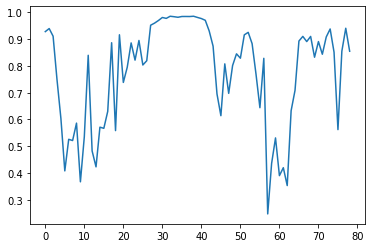

In [288]:
#plt.plot(all_scores)
a1 = []
for k in all_scores:
    if len(k) > 0:
        a1.append(k[0])
    else:
        a1.append(0)
plt.plot(a1)

In [172]:
# [STAR] For checking the predictions slice wise for the Validation set

def collate_fn(batch):
    return tuple(zip(*batch))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt26.pth'))
model.eval()

#valid_dataset     = DBTDatasetValidationTrain(val_index=i)
valid_dataset     = DBTDataset(train_set=0)
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1, 
    collate_fn=collate_fn
)
        
all_target = []
all_scores = []
all_images = []

for images, targets, image_ids in valid_data_loader:
    all_images.append(images[0][0].astype('float16'))
    new_images  = []
    for img in images:
        new_images.append(torch.Tensor(img).to(device))

    images    = new_images
    targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images)
    #print(loss_dict)

    all_scores.append(loss_dict[0]['scores'].data.cpu().numpy())
    all_target.append(loss_dict[0]['boxes'].data.cpu().numpy())
        

READING NEW FILE >>    <<
Total size of dataset  224


In [290]:
# 10 epoch  42
# 20 epochs 57
# 30 epochs 59, 57, 55
# 40 epochs 53

Total validation length  224
DBT-P03073,DBT-S04591,lcc,331,417,1040,458,23,8,0.8215158
DBT-P03073,DBT-S04591,lcc,271,525,1055,486,28,8,0.959689
DBT-P03073,DBT-S04591,lcc,308,383,1096,415,33,8,0.98365015
DBT-P03073,DBT-S04591,lmlo,250,125,627,92,22,8,0.97866577
DBT-P03073,DBT-S04591,lmlo,508,433,951,423,30,8,0.9719445
DBT-P03073,DBT-S04591,lmlo,413,567,927,480,40,8,0.9296037
DBT-P03073,DBT-S04591,lmlo,651,259,1017,263,56,8,0.9705861
DBT-P03073,DBT-S04591,lmlo,250,125,627,92,22,8,0.97866577
DBT-P03073,DBT-S04591,lmlo,508,433,951,423,30,8,0.9719445
DBT-P03073,DBT-S04591,lmlo,413,567,927,480,40,8,0.9296037
DBT-P03073,DBT-S04591,lmlo,651,259,1017,263,56,8,0.9705861
DBT-P03085,DBT-S00863,lcc,196,251,1354,207,27,8,0.98632765
DBT-P03085,DBT-S00863,lcc,12,122,635,106,39,8,0.9690986
DBT-P03085,DBT-S00863,lmlo,378,102,429,103,20,8,0.9636856
DBT-P03085,DBT-S00863,lmlo,167,246,1155,211,35,8,0.98484904
DBT-P03085,DBT-S00863,lmlo,174,223,1167,191,39,8,0.981952
DBT-P03085,DBT-S00863,lmlo,168,247,1157,

[42]


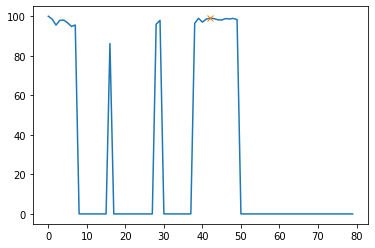

In [163]:
all1 = []
for t in all_scores:
    if len(t) > 0 and t[0] > 0.5:
        #print(t[0])
        all1.append(t[0])
    else:
        all1.append(0)


d_init_x = -1
d_init_y = -1
d_init_z = -1
all1     = []

for i, t in enumerate(all_scores):
    if len(t) > 0 and t[0] > 0.5:
        if d_init_x == -1:
            d_init_x = all_target[i][0][0]
            d_init_y = all_target[i][0][1]
            d_init_z = i
        
        temp_dist = np.min([100, np.linalg.norm([all_target[i][0][0]-d_init_x, all_target[i][0][1]-d_init_y, i-d_init_z])])
        all1.append(temp_dist)
        d_init_x = all_target[i][0][0]
        d_init_y = all_target[i][0][1]
        d_init_z = i
    else:
        all1.append(100)
all1 = 100-np.array(all1)

from scipy.signal import find_peaks

peaks, _ = find_peaks(all1, distance=8, width=4)
#print(a.shape)
plt.plot(all1)
plt.plot(peaks, all1[peaks], 'x')
print(peaks)

slice location  0 49
[[  2.   273.25  44.   388.75]]


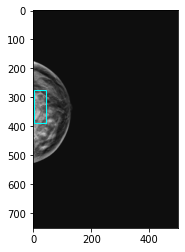

In [32]:
case_index   = 0#random.randint(0, len(valid_dataset))
img, all_target, _    = valid_dataset[case_index]
img          = img.astype('float32')
#img        = a.astype('float32')
#case_index = 0#random.randint(0, img.shape[0]-1)
#case_index = peaks[0]-5
plt.imshow(img[0], cmap='gray')
ax   = plt.gca()
case_index  = 0
print('slice location ', case_index, len(valid_dataset))

if 1:#len(all_target[case_index]) > 0 and all_scores[case_index][0] > 0.2:
    temp  = all_target['boxes'].data.cpu().numpy()#[case_index]
    print(temp)
    #print(case_index, all_scores[case_index])
    index = 0
    #rect  = patches.Rectangle((temp[0], temp[1]), temp[2]-temp[0], temp[3]-temp[1], linewidth=1, edgecolor='cyan', fill = False)
    rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
    ax.add_patch(rect)
else:
    print('Not found 8')

plt.show()
case_index = case_index+1

In [ ]:
# Validation Iteration #10 loss: 0.26083502173423767
# Validation Iteration #20 loss: 0.12475015223026276
# Validation Iteration #30 loss: 0.2311360090970993
# Validation Iteration #40 loss: 0.07870643585920334
# Validation Iteration #50 loss: 0.12904797494411469
# 0.17835015669465065

# Validation Iteration #10 loss: 0.16890683770179749
# Validation Iteration #20 loss: 0.12697485089302063
# Validation Iteration #30 loss: 0.202874094247818
# Validation Iteration #40 loss: 0.1275915801525116
# Validation Iteration #50 loss: 0.16607160866260529
# 0.17254152543842793

# Validation Iteration #10 loss: 0.14864173531532288
# Validation Iteration #20 loss: 0.13806253671646118
# Validation Iteration #30 loss: 0.13079851865768433
# Validation Iteration #40 loss: 0.09259304404258728
# Validation Iteration #50 loss: 0.13366109132766724
# 0.1608045955002308

# Validation Iteration #10 loss: 0.2190426141023636
# Validation Iteration #20 loss: 0.10993507504463196
# Validation Iteration #30 loss: 0.08774184435606003
# Validation Iteration #40 loss: 0.14777813851833344
# Validation Iteration #50 loss: 0.08807449787855148
# 0.1679838129878044

# fasterrcnn_resnet50_dbt22.pth
# Validation Iteration #10 loss: 0.12817245721817017
# Validation Iteration #20 loss: 0.3029731810092926
# Validation Iteration #30 loss: 0.06146375834941864
# Validation Iteration #40 loss: 0.08439958095550537
# Validation Iteration #50 loss: 0.059381939470767975
# 0.10177689090371132

In [ ]:
# [STAR] For doing inference of the model

all_target = []
all_scores = []

#device = torch.device("cpu")
#model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt22.pth'))
model.eval()



for images, targets, image_ids in valid_data_loader:
    new_images  = []
    for img in images:
        new_images.append(torch.Tensor(img).to(device))

    images    = new_images
    targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images)
    print(loss_dict)
    
    #print(loss_dict[0]['boxes'].data.cpu().numpy())
    
    all_scores.append(loss_dict[0]['scores'].data.cpu().numpy())
    all_target.append(loss_dict[0]['boxes'].data.cpu().numpy())

{'boxes': tensor([ 271, 1057,  805, 1490])}
Ground Truth  [ 271 1057  805 1490] 35
Prediction  [[ 75.71501  283.47375  163.6579   378.79547 ]
 [  4.241309 263.63602   50.325714 373.7304  ]
 [101.045715 287.99136  151.38869  370.79993 ]
 [ 61.922516 258.55548  184.89377  395.74182 ]]
Scores  [0.97706246 0.4141349  0.13911489 0.10131314]
Prediction  [[ 75.71501  283.47375  163.6579   378.79547 ]
 [  4.241309 263.63602   50.325714 373.7304  ]
 [101.045715 287.99136  151.38869  370.79993 ]
 [ 61.922516 258.55548  184.89377  395.74182 ]]
[ 67 264 201 372]


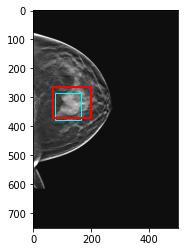

In [257]:
# [STAR] Code to compare the ground truth and predicted mask


case_index   = 35#random.randint(0, len(valid_dataset)-1)
images, b, c = valid_dataset[case_index]
print(b)

print('Ground Truth ', b['boxes'].data.cpu().numpy(), case_index)
print('Prediction ', all_target[case_index])
print('Scores ', all_scores[case_index])

plt.imshow(images[0], cmap='gray')
ax   = plt.gca()

# if(len(all_target1[case_index]) > 0):
#     #print(all_target1[index])
#     #print(all_scores1[index])
    
#     temp  = all_target1[case_index]
#     index = 0
#     rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='yellow', fill = False)
#     ax.add_patch(rect)
# else:
#     print('Not found 9')

if(len(all_target[case_index]) > 0):
    #print(all_target[index])
    #print(all_scores[index])
    
    temp  = all_target[case_index]
    print('Prediction ', temp)
    index = 0
    rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
    ax.add_patch(rect)
else:
    print('Not found 8')

temp  = b['boxes'].data.cpu().numpy()//4#all_target[index]
index = 0
print(temp)
rect  = patches.Rectangle((temp[0], temp[1]), temp[2]-temp[0], temp[3]-temp[1], linewidth=1, edgecolor='red', fill = False)
ax.add_patch(rect)


#rect = patches.Rectangle((0, 0), 500, 100, linewidth=2, edgecolor='cyan', fill = False)

plt.show()
case_index = case_index+1

In [ ]:
# Error cases for fasterrcnn_resnet50_dbt15.pth
Ground Truth  [[ 10.75 304.    51.25 333.75]] 5
Ground Truth  [[ 19.   416.25  63.5  447.75]] 6
Ground Truth  [[188.25 309.5  216.5  369.75]] 7
Ground Truth  [[193.25 389.5  228.   453.5 ]] 8
Ground Truth  [[463.75 150.5  498.5  222.75]] 14
Ground Truth  [[170.   335.25 195.5  362.25]] 23
Ground Truth  [[345.25 414.5  472.25 536.5 ]] 30
Ground Truth  [[451.5  333.75 496.   382.  ]] 34
Ground Truth  [[398.   166.75 468.25 222.  ]] 37
Ground Truth  [[317.75 332.75 388.75 394.  ]] 44
Ground Truth  [[  2.   273.25  44.   388.75]] 45
Ground Truth  [[5.0000e-01 3.9825e+02 6.1500e+01 5.1375e+02]] 46

# Error cases for fasterrcnn_resnet50_dbt14.pth
Ground Truth  [[188.25 309.5  216.5  369.75]] 7
Ground Truth  [[193.25 389.5  228.   453.5 ]] 8
Ground Truth  [[317.75 332.75 388.75 394.  ]] 44
Ground Truth  [[299.25 347.75 324.25 387.  ]] 48

In [9]:
dbtvol = np.fromfile('/media/drilnvm/ubuntudata2/TEST-DBT-RECONS/04140608-LE-L-CC_3000x1200x80.4_0.0005_-0.2_1_15.raw', dtype=np.float32)
dbtvol = np.reshape(dbtvol, [80, 1200, 3000])
print(dbtvol.shape)

(80, 1200, 3000)
